# PHÂN TÍCH CHẤT LƯỢNG KHÔNG KHÍ

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

Trong lĩnh vực khoa học dữ liệu và mô hình hóa thống kê, việc xử lý dữ liệu cao chiều (high-dimensional data) với đa cộng tuyến giữa các biến dự báo là một thách thức phổ biến. Các kỹ thuật hồi quy truyền thống thường gặp khó khăn trong các tình huống như vậy, dẫn đến ước tính không ổn định và hiệu suất dự báo kém. Để giải quyết các vấn đề này, các kỹ thuật giảm chiều như Hồi quy thành phần chính (Principal Component Regression - PCR) và Hồi quy bình phương tối tiểu riêng phần (Partial Least Squares Regression - PLS) được sử dụng. Trong đồ án này, chúng tôi thực nghiệm nghiên cứu và áp dụng hai kỹ thuật này thông qua bộ dữ liệu thực tế về đánh giá chất lượng không khí.

## Phát biểu bài toán

Trong đồ án này, chúng tôi quan tâm đến vấn đề chất lượng không khí mà trong đó chúng tôi quan tâm đến nồng độ chất C6H6 (benzene), được ký hiệu trong dữ liệu là C6H6(GT) dựa trên ý nghĩa của nó đối với sức khỏe cộng đồng và môi trường môi sinh. Benzen là một chất gây ô nhiễm chính, được phân loại là chất gây ung thư và sự hiện diện của nó trong khí quyển có liên quan chặt chẽ đến nhiều nguy cơ sức khỏe, bao gồm cả tỷ lệ ung thư gia tăng. Ngoài ra, nồng độ benzen đóng vai trò là chỉ số về khí thải từ phương tiện giao thông và công nghiệp, đây là những mối quan tâm chính trong quản lý ô nhiễm đô thị.

Ý nghĩa của đồ án này nằm ở việc phân tích và đưa ra các thông tin hữu ích có giá trị từ khảo sát dữ liệu chất lượng không khí, từ đó giúp người quản lý có thể đưa ra những chiến lược phù hợp nhằm cải thiện chất lượng không khí.

## Giới thiệu về dữ liệu

Bộ dữ liệu này, The Air Quality Dataset, được lấy từ UCI Machine Learning Repository, chứa các chỉ số đo đạt các chất gây ô nhiễm không khí và các biến số khí tượng khác nhau được thu thập tại một trạm giám sát của Ý. Bộ dữ liệu bao gồm các phép đo hàng ngày về các chất gây ô nhiễm như ôzôn, nitơ điôxít và cacbon monoxit, cũng như các biến số khí tượng như nhiệt độ, tốc độ gió và độ ẩm. Với hơn 9.000 quan trắc, bộ dữ liệu này cung cấp một nguồn dữ liệu phong phú để phân tích.

Trong đồ án này, biến mục tiêu là một trong những chất gây ô nhiễm, cho phép sử dụng các mô hình hồi quy như PCR và PLS để dự đoán chất lượng không khí dựa trên các yếu tố dự báo sẵn có.

## Các câu hỏi phân tích

## Import thư viện

In [2]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)

library(pls)
# library(caret)

## Hàm phụ trợ

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {      
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read_excel("../../data/part2/air+quality/AirQualityUCI.xlsx", sheet = 1)
str(raw_data)

tibble [9,357 × 15] (S3: tbl_df/tbl/data.frame)
 $ Date         : POSIXct[1:9357], format: "2004-03-10" "2004-03-10" ...
 $ Time         : POSIXct[1:9357], format: "1899-12-31 18:00:00" "1899-12-31 19:00:00" ...
 $ CO(GT)       : num [1:9357] 2.6 2 2.2 2.2 1.6 1.2 1.2 1 0.9 0.6 ...
 $ PT08.S1(CO)  : num [1:9357] 1360 1292 1402 1376 1272 ...
 $ NMHC(GT)     : num [1:9357] 150 112 88 80 51 38 31 31 24 19 ...
 $ C6H6(GT)     : num [1:9357] 11.88 9.4 9 9.23 6.52 ...
 $ PT08.S2(NMHC): num [1:9357] 1046 955 939 948 836 ...
 $ NOx(GT)      : num [1:9357] 166 103 131 172 131 89 62 62 45 -200 ...
 $ PT08.S3(NOx) : num [1:9357] 1056 1174 1140 1092 1205 ...
 $ NO2(GT)      : num [1:9357] 113 92 114 122 116 96 77 76 60 -200 ...
 $ PT08.S4(NO2) : num [1:9357] 1692 1559 1554 1584 1490 ...
 $ PT08.S5(O3)  : num [1:9357] 1268 972 1074 1203 1110 ...
 $ T            : num [1:9357] 13.6 13.3 11.9 11 11.2 ...
 $ RH           : num [1:9357] 48.9 47.7 54 60 59.6 ...
 $ AH           : num [1:9357] 0.758 0.72

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 231 dòng và 14 cột
dim(raw_data)

[1] 9357   15

In [5]:
head(raw_data)

Date       Time                CO(GT) PT08.S1(CO) NMHC(GT) C6H6(GT) 
1 2004-03-10 1899-12-31 18:00:00 2.6    1360.00     150      11.881723
2 2004-03-10 1899-12-31 19:00:00 2.0    1292.25     112       9.397165
3 2004-03-10 1899-12-31 20:00:00 2.2    1402.00      88       8.997817
4 2004-03-10 1899-12-31 21:00:00 2.2    1375.50      80       9.228796
5 2004-03-10 1899-12-31 22:00:00 1.6    1272.25      51       6.518224
6 2004-03-10 1899-12-31 23:00:00 1.2    1197.00      38       4.741012
  PT08.S2(NMHC) NOx(GT) PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3) T     
1 1045.50       166     1056.25      113     1692.00      1267.50     13.600
2  954.75       103     1173.75       92     1558.75       972.25     13.300
3  939.25       131     1140.00      114     1554.50      1074.00     11.900
4  948.25       172     1092.00      122     1583.75      1203.25     11.000
5  835.50       131     1205.00      116     1490.00      1110.00     11.150
6  750.25        89     1336.50       96     1393.00       949.25     11.175
  RH     AH       
1 48.875 0.7577538
2 47.700 0.7254874
3 53.975 0.7502391
4 60.000 0.7867125
5 59.575 0.7887942
6 59.175 0.7847717

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Date Time CO(GT) PT08.S1(CO) NMHC(GT) C6H6(GT) PT08.S2(NMHC) NOx(GT)
     PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3) T RH AH

### Mỗi cột mang ý nghĩa gì?

In [7]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

tibble [9,357 × 15] (S3: tbl_df/tbl/data.frame)
 $ Date         : POSIXct[1:9357], format: "2004-03-10" "2004-03-10" ...
 $ Time         : POSIXct[1:9357], format: "1899-12-31 18:00:00" "1899-12-31 19:00:00" ...
 $ CO(GT)       : num [1:9357] 2.6 2 2.2 2.2 1.6 1.2 1.2 1 0.9 0.6 ...
 $ PT08.S1(CO)  : num [1:9357] 1360 1292 1402 1376 1272 ...
 $ NMHC(GT)     : num [1:9357] 150 112 88 80 51 38 31 31 24 19 ...
 $ C6H6(GT)     : num [1:9357] 11.88 9.4 9 9.23 6.52 ...
 $ PT08.S2(NMHC): num [1:9357] 1046 955 939 948 836 ...
 $ NOx(GT)      : num [1:9357] 166 103 131 172 131 89 62 62 45 -200 ...
 $ PT08.S3(NOx) : num [1:9357] 1056 1174 1140 1092 1205 ...
 $ NO2(GT)      : num [1:9357] 113 92 114 122 116 96 77 76 60 -200 ...
 $ PT08.S4(NO2) : num [1:9357] 1692 1559 1554 1584 1490 ...
 $ PT08.S5(O3)  : num [1:9357] 1268 972 1074 1203 1110 ...
 $ T            : num [1:9357] 13.6 13.3 11.9 11 11.2 ...
 $ RH           : num [1:9357] 48.9 47.7 54 60 59.6 ...
 $ AH           : num [1:9357] 0.758 0.72

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

| Tên biến      | Vai trò | Phân loại               | Mô tả                                                                                                                             | Đơn vị     | Missing Values |
| ------------- | ------- | ----------------------- | --------------------------------------------------------------------------------------------------------------------------------- | ---------- | -------------- |
| Date          | Feature | Date (Ngày tháng năm)   | Ngày tháng mà các giá trị độ đo được thu thập.                                                                                    |            | Không          |
| Time          | Feature | Categorical (Phân loại) | Thời gian mà các giá trị độ đo được thu thập.                                                                                     |            | Không          |
| CO(GT)        | Feature | Integer (Nguyên)        | Nồng độ CO (carbon monoxide) trung bình thực tế theo giờ tính bằng mg/m^3 (máy phân tích tham chiếu)                              | mg/m^3     | Không          |
| PT08.S1(CO)   | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với carbon monoxide.              |            | Không          |
| NMHC(GT)      | Feature | Integer (Nguyên)        | Nồng độ Non Metanic HydroCarbons trong không khí (đơn vị microg/m^3/ trung bình theo giờ/ dựa trên máy phân tích tham chiếu)      | microg/m^3 | Không          |
| C6H6(GT)      | Feature | Continuous              | Nồng độ trung bình Benzene trong không khí (đơn vị microg/m^3/ trung bình theo giờ/ dựa trên máy phân tích tham chiếu)            | microg/m^3 | Không          |
| PT08.S2(NMHC) | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với Non Metanic HydroCarbons      |            | Không          |
| NOx(GT)       | Feature | Integer (Nguyên)        | Nồng độ trung bình NOx (oxit nitơ) trong không khí (đơn vị PPB/ trung bình theo giờ/ dựa trên máy phân tích tham chiếu)           | ppb        | Không          |
| PT08.S3(NOx)  | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với NOx (oxit nitơ)               |            | Không          |
| NO2(GT)       | Feature | Integer (Nguyên)        | Nồng độ trung bình NO2 (nitơ dioxit) trong không khí (đơn vị microg/m^3 / trung bình theo giờ/ dựa trên máy phân tích tham chiếu) | microg/m^3 | Không          |
| PT08.S4(NO2)  | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với NO2 (nitơ dioxit)             |            | Không          |
| PT08.S5(O3)   | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với O3                            |            | Không          |
| T             | Feature | Continuous (Liên tục)   | Nhiệt độ (Thang độ Celsius)                                                                                                       | °C         | Không          |
| RH            | Feature | Continuous (Liên tục)   | Độ ẩm tương đối (Relative Humidity)                                                                                               | %          | Không          |
| AH            | Feature | Continuous (Liên tục)   | Độ ẩm tuyệt đối (Absolute Humidity)                                                                                               |            | Không          |


In [8]:
# 1. Time
is.factor(raw_data$Time) #False 

# 2. PT08.S1(CO)
is.factor(raw_data$`PT08.S1(CO)`) # False

# 3. PT08.S2(NMHC)
is.factor(raw_data$`PT08.S2(NMHC)`) # False

# 4. PT08.S3(NOx)
is.factor(raw_data$`PT08.S3(NOx)`) # False

# 5. PT08.S4(NO2)
is.factor(raw_data$`PT08.S4(NO2)`) # False

# 6. PT08.S5(O3)
is.factor(raw_data$`PT08.S5(O3)`) # False

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

In [9]:
# Convert character columns to numeric, except for Date and Time
cols_to_convert <- setdiff(names(raw_data), c("Date", "Time"))

In [10]:
# Use mutate to convert columns to numeric
air_quality <- raw_data %>% mutate(across(all_of(cols_to_convert), ~ as.numeric(gsub(",", ".", .))))
head(air_quality)

Date       Time                CO(GT) PT08.S1(CO) NMHC(GT) C6H6(GT) 
1 2004-03-10 1899-12-31 18:00:00 2.6    1360.00     150      11.881723
2 2004-03-10 1899-12-31 19:00:00 2.0    1292.25     112       9.397165
3 2004-03-10 1899-12-31 20:00:00 2.2    1402.00      88       8.997817
4 2004-03-10 1899-12-31 21:00:00 2.2    1375.50      80       9.228796
5 2004-03-10 1899-12-31 22:00:00 1.6    1272.25      51       6.518224
6 2004-03-10 1899-12-31 23:00:00 1.2    1197.00      38       4.741012
  PT08.S2(NMHC) NOx(GT) PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3) T     
1 1045.50       166     1056.25      113     1692.00      1267.50     13.600
2  954.75       103     1173.75       92     1558.75       972.25     13.300
3  939.25       131     1140.00      114     1554.50      1074.00     11.900
4  948.25       172     1092.00      122     1583.75      1203.25     11.000
5  835.50       131     1205.00      116     1490.00      1110.00     11.150
6  750.25        89     1336.50       96     1393.00       949.25     11.175
  RH     AH       
1 48.875 0.7577538
2 47.700 0.7254874
3 53.975 0.7502391
4 60.000 0.7867125
5 59.575 0.7887942
6 59.175 0.7847717

In [11]:
# # Modifications
# raw_data$Time <- as.factor(raw_data$Time)
# raw_data$`PT08.S1(CO)` <- as.factor(raw_data$`PT08.S1(CO)`)
# raw_data$`PT08.S2(NMHC)` <- as.factor(raw_data$`PT08.S2(NMHC)`)
# raw_data$`PT08.S3(NOx)` <- as.factor(raw_data$`PT08.S3(NOx)`)
# raw_data$`PT08.S4(NO2)` <- as.factor(raw_data$`PT08.S4(NO2)`)
# raw_data$`PT08.S5(O3)` <- as.factor(raw_data$`PT08.S5(O3)`)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [12]:
# Hàm tính toán tỷ lệ missing values
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [13]:
# Lựa chọn các kiểu số
num_col_info_df <- as.data.frame(air_quality) %>% select_if(is.numeric)

# Tổng hợp thông tin thống kê mô tả
num_col_info_df <- as.data.frame(air_quality) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 39 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 13 × 7
   variable      missing   min  lower median  upper     max
   <chr>           <dbl> <dbl>  <dbl>  <dbl>  <dbl>   <dbl>
 1 CO(GT)              0  -200    0.6    1.5    2.6   11.9 
 2 PT08.S1(CO)         0  -200  921   1052.  1221.  2040.  
 3 NMHC(GT)            0  -200 -200   -200   -200   1189   
 4 C6H6(GT)            0  -200    4      7.9   13.6   63.7 
 5 PT08.S2(NMHC)       0  -200  711    894.  1105.  2214   
 6 NOx(GT)             0  -200   50    141    284.  1479   
 7 PT08.S3(NOx)        0  -200  637    794.   960.  2683.  
 8 NO2(GT)             0  -200   53     96    133    340.  
 9 PT08.S4(NO2)        0  -200 1185.  1446.  1662   2775   
10 PT08.S5(O3)         0  -200  700.   942   1255.  2523.  
11 T                   0  -200   10.9   17.2   24.1   44.6 
12 RH                  0  -200   34.1   48.6   61.9   88.7 
13 AH                  0  -200    0.7    1      1.3    2.23


**Nhận xét**
- Dữ liệu không có hiện tượng missing values. 
- Dữ liệu có giá trị âm đối với các cột có kiểu số, điều này là bất thường, cần được loại bỏ.

In [14]:
print(summary(as.data.frame(air_quality) %>% select_if(is.numeric)))

     CO(GT)         PT08.S1(CO)      NMHC(GT)         C6H6(GT)       
 Min.   :-200.00   Min.   :-200   Min.   :-200.0   Min.   :-200.000  
 1st Qu.:   0.60   1st Qu.: 921   1st Qu.:-200.0   1st Qu.:   4.005  
 Median :   1.50   Median :1052   Median :-200.0   Median :   7.887  
 Mean   : -34.21   Mean   :1049   Mean   :-159.1   Mean   :   1.866  
 3rd Qu.:   2.60   3rd Qu.:1221   3rd Qu.:-200.0   3rd Qu.:  13.636  
 Max.   :  11.90   Max.   :2040   Max.   :1189.0   Max.   :  63.741  
 PT08.S2(NMHC)       NOx(GT)        PT08.S3(NOx)       NO2(GT)       
 Min.   :-200.0   Min.   :-200.0   Min.   :-200.0   Min.   :-200.00  
 1st Qu.: 711.0   1st Qu.:  50.0   1st Qu.: 637.0   1st Qu.:  53.00  
 Median : 894.5   Median : 141.0   Median : 794.2   Median :  96.00  
 Mean   : 894.5   Mean   : 168.6   Mean   : 794.9   Mean   :  58.14  
 3rd Qu.:1104.8   3rd Qu.: 284.2   3rd Qu.: 960.2   3rd Qu.: 133.00  
 Max.   :2214.0   Max.   :1479.0   Max.   :2682.8   Max.   : 339.70  
  PT08.S4(NO2)   PT0

In [15]:
# # Gán các giá trị bé hơn 0, bằng 0
replace_negatives <- function(x) {
  x[x == -200] <- NA
  return(x)
}

air_quality <- as.data.frame(lapply(air_quality, replace_negatives))
air_quality  <- na.omit(air_quality)

In [16]:
print(summary(as.data.frame(air_quality) %>% select_if(is.numeric)))

     CO.GT.       PT08.S1.CO.        NMHC.GT.         C6H6.GT.      
 Min.   :0.300   Min.   : 752.5   Min.   :   7.0   Min.   : 0.5428  
 1st Qu.:1.300   1st Qu.:1016.9   1st Qu.:  77.0   1st Qu.: 4.8043  
 Median :2.000   Median :1172.0   Median : 157.0   Median : 9.1258  
 Mean   :2.354   Mean   :1207.7   Mean   : 231.0   Mean   :10.7724  
 3rd Qu.:3.100   3rd Qu.:1380.2   3rd Qu.: 318.5   3rd Qu.:14.8032  
 Max.   :8.100   Max.   :2039.8   Max.   :1189.0   Max.   :39.2023  
 PT08.S2.NMHC.       NOx.GT.       PT08.S3.NOx.       NO2.GT.     
 Min.   : 447.5   Min.   : 12.0   Min.   : 461.2   Min.   : 19.0  
 1st Qu.: 753.5   1st Qu.: 81.0   1st Qu.: 768.9   1st Qu.: 78.5  
 Median : 944.2   Median :128.0   Median : 920.0   Median : 99.0  
 Mean   : 966.0   Mean   :143.5   Mean   : 963.2   Mean   :100.3  
 3rd Qu.:1142.4   3rd Qu.:187.0   3rd Qu.:1131.0   3rd Qu.:122.0  
 Max.   :1754.2   Max.   :478.0   Max.   :1934.5   Max.   :196.0  
  PT08.S4.NO2.   PT08.S5.O3.           T        

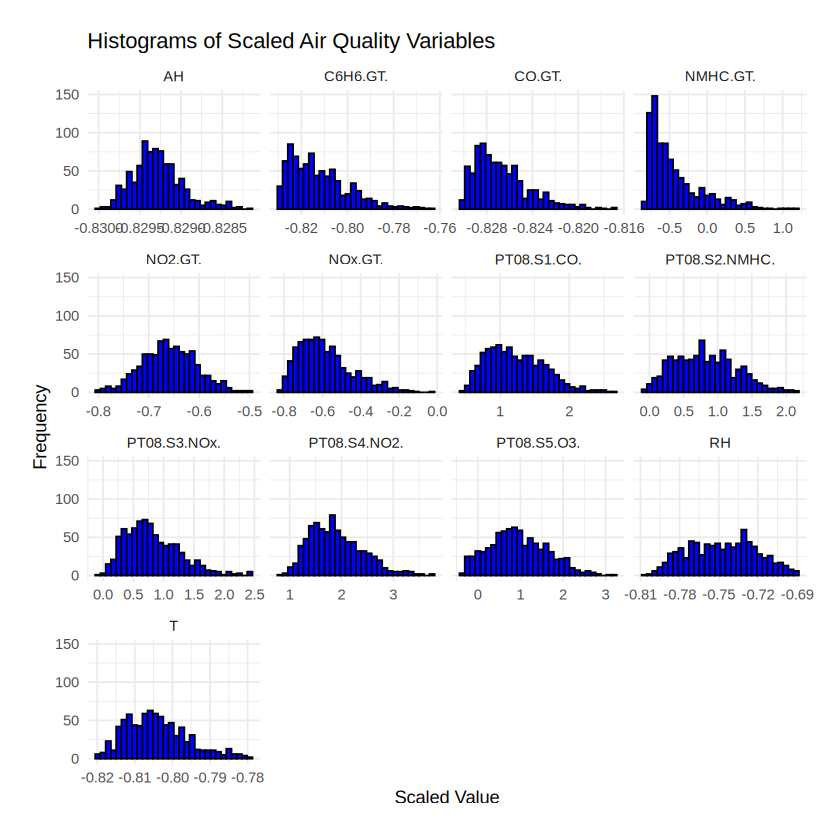

In [17]:
# Converting data to long format and scaling the values
air_quality_long <- air_quality %>%
  pivot_longer(cols = -c(Date, Time), names_to = "variable", values_to = "value") %>%
  mutate(value = scale(value))  # Scale the data

# 1. Histograms of Scaled Data
ggplot(air_quality_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  facet_wrap(~ variable, scales = "free_x") +
  theme_minimal() +
  theme(plot.margin = margin(20, 20, 20, 20)) +
  labs(title = "Histograms of Scaled Air Quality Variables",
       x = "Scaled Value",
       y = "Frequency")

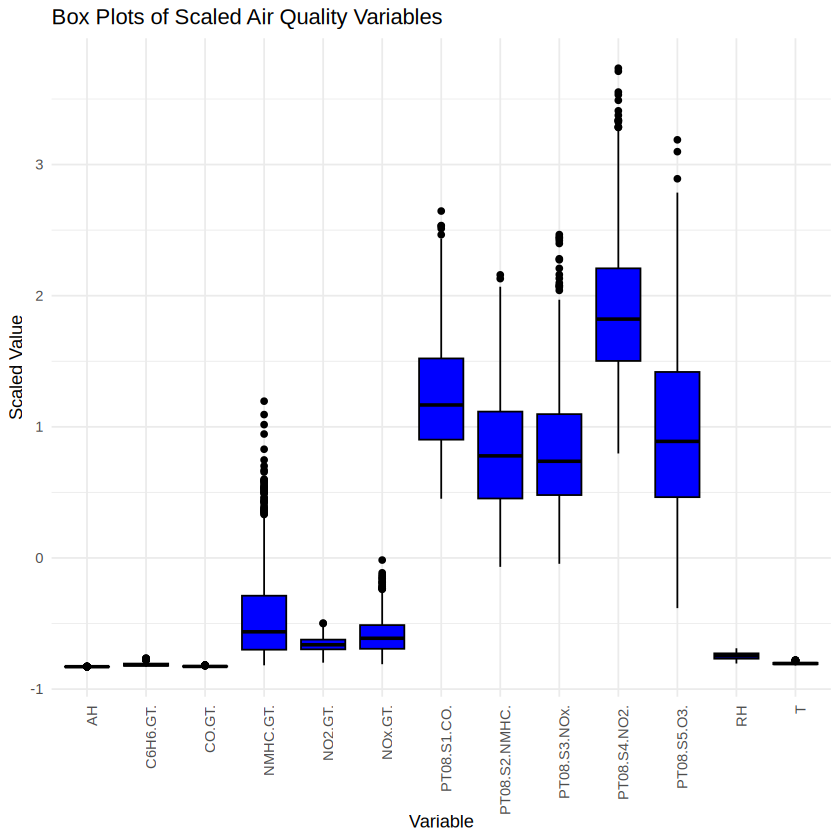

In [18]:
# 2. Box Plots of Scaled Data
ggplot(air_quality_long, aes(x = variable, y = value)) +
  geom_boxplot(fill = "blue", color = "black") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Box Plots of Scaled Air Quality Variables",
       x = "Variable",
       y = "Scaled Value")

### Tương quan giữa các biến

In [19]:
cor_matrix <- cor(air_quality[, -c(1, 2)])
cor_matrix

CO.GT.     PT08.S1.CO. NMHC.GT.   C6H6.GT.   PT08.S2.NMHC.
CO.GT.         1.0000000  0.93625751  0.8871675  0.9726721  0.9584438   
PT08.S1.CO.    0.9362575  1.00000000  0.7817577  0.9314037  0.9363635   
NMHC.GT.       0.8871675  0.78175770  1.0000000  0.8979706  0.8750557   
C6H6.GT.       0.9726721  0.93140372  0.8979706  1.0000000  0.9847953   
PT08.S2.NMHC.  0.9584438  0.93636351  0.8750557  0.9847953  1.0000000   
NOx.GT.        0.9513417  0.92289377  0.8111820  0.9273347  0.9266433   
PT08.S3.NOx.  -0.8237093 -0.82955186 -0.7742074 -0.8487096 -0.9106217   
NO2.GT.        0.8614319  0.86657376  0.7280519  0.8467397  0.8850266   
PT08.S4.NO2.   0.9399222  0.94500552  0.8484989  0.9608512  0.9578822   
PT08.S5.O3.    0.8829421  0.93500389  0.7619088  0.8969917  0.9091092   
T              0.3184677  0.32493661  0.3670813  0.4182663  0.4457236   
RH            -0.1051946 -0.03959163 -0.1603084 -0.1780818 -0.1933548   
AH             0.2955889  0.40701824  0.2821367  0.3136056  0.3252835   
              NOx.GT.    PT08.S3.NOx. NO2.GT.    PT08.S4.NO2. PT08.S5.O3.
CO.GT.         0.9513417 -0.8237093    0.8614319  0.93992217   0.88294206
PT08.S1.CO.    0.9228938 -0.8295519    0.8665738  0.94500552   0.93500389
NMHC.GT.       0.8111820 -0.7742074    0.7280519  0.84849890   0.76190880
C6H6.GT.       0.9273347 -0.8487096    0.8467397  0.96085119   0.89699170
PT08.S2.NMHC.  0.9266433 -0.9106217    0.8850266  0.95788220   0.90910919
NOx.GT.        1.0000000 -0.8142880    0.8574250  0.91271751   0.89337856
PT08.S3.NOx.  -0.8142880  1.0000000   -0.8152130 -0.88019948  -0.85753138
NO2.GT.        0.8574250 -0.8152130    1.0000000  0.80776437   0.83964820
PT08.S4.NO2.   0.9127175 -0.8801995    0.8077644  1.00000000   0.91897694
PT08.S5.O3.    0.8933786 -0.8575314    0.8396482  0.91897694   1.00000000
T              0.2384995 -0.4240835    0.4069110  0.34374477   0.31356074
RH            -0.0420203  0.0968696   -0.2230349  0.01234292  -0.01457537
AH             0.2706760 -0.4630067    0.2145621  0.51555945   0.44017120
              T          RH          AH        
CO.GT.         0.3184677 -0.10519461  0.2955889
PT08.S1.CO.    0.3249366 -0.03959163  0.4070182
NMHC.GT.       0.3670813 -0.16030845  0.2821367
C6H6.GT.       0.4182663 -0.17808184  0.3136056
PT08.S2.NMHC.  0.4457236 -0.19335476  0.3252835
NOx.GT.        0.2384995 -0.04202030  0.2706760
PT08.S3.NOx.  -0.4240835  0.09686960 -0.4630067
NO2.GT.        0.4069110 -0.22303494  0.2145621
PT08.S4.NO2.   0.3437448  0.01234292  0.5155594
PT08.S5.O3.    0.3135607 -0.01457537  0.4401712
T              1.0000000 -0.77013521  0.1597732
RH            -0.7701352  1.00000000  0.4757342
AH             0.1597732  0.47573420  1.0000000

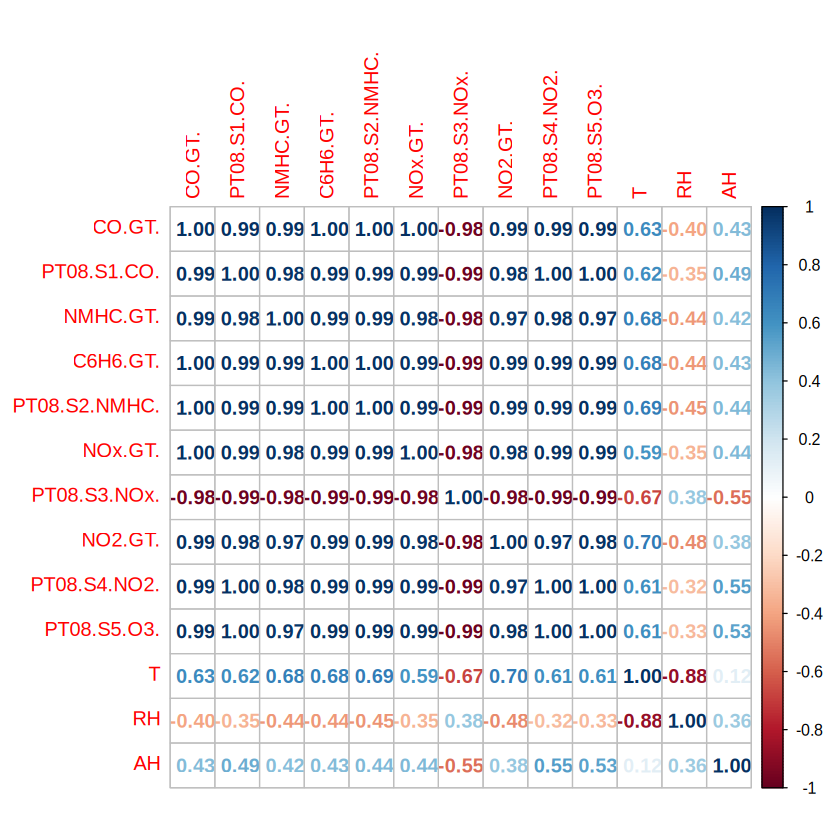

In [21]:
library(corrplot)
corrplot(round(cor(cor_matrix), 2), method="number")

In [22]:
threshold <- 0.7
high_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(abs(cor_matrix[i, j]) > threshold) {
      high_cor_pairs <- rbind(high_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(high_cor_pairs)

            Var1          Var2      value
1         CO.GT.   PT08.S1.CO.  0.9362575
2         CO.GT.      NMHC.GT.  0.8871675
3         CO.GT.      C6H6.GT.  0.9726721
4         CO.GT. PT08.S2.NMHC.  0.9584438
5         CO.GT.       NOx.GT.  0.9513417
6         CO.GT.  PT08.S3.NOx. -0.8237093
7         CO.GT.       NO2.GT.  0.8614319
8         CO.GT.  PT08.S4.NO2.  0.9399222
9         CO.GT.   PT08.S5.O3.  0.8829421
10   PT08.S1.CO.      NMHC.GT.  0.7817577
11   PT08.S1.CO.      C6H6.GT.  0.9314037
12   PT08.S1.CO. PT08.S2.NMHC.  0.9363635
13   PT08.S1.CO.       NOx.GT.  0.9228938
14   PT08.S1.CO.  PT08.S3.NOx. -0.8295519
15   PT08.S1.CO.       NO2.GT.  0.8665738
16   PT08.S1.CO.  PT08.S4.NO2.  0.9450055
17   PT08.S1.CO.   PT08.S5.O3.  0.9350039
18      NMHC.GT.      C6H6.GT.  0.8979706
19      NMHC.GT. PT08.S2.NMHC.  0.8750557
20      NMHC.GT.       NOx.GT.  0.8111820
21      NMHC.GT.  PT08.S3.NOx. -0.7742074
22      NMHC.GT.       NO2.GT.  0.7280519
23      NMHC.GT.  PT08.S4.NO2.  0.

In [23]:
threshold <- 0

neg_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(cor_matrix[i, j] < threshold) {
      neg_cor_pairs <- rbind(neg_cor_pairs, 
                             data.frame(Var1 = rownames(cor_matrix)[i], 
                                        Var2 = colnames(cor_matrix)[j], 
                                        value = cor_matrix[i, j]))
    }
  }
}

print(neg_cor_pairs)

            Var1         Var2       value
1         CO.GT. PT08.S3.NOx. -0.82370926
2         CO.GT.           RH -0.10519461
3    PT08.S1.CO. PT08.S3.NOx. -0.82955186
4    PT08.S1.CO.           RH -0.03959163
5       NMHC.GT. PT08.S3.NOx. -0.77420740
6       NMHC.GT.           RH -0.16030845
7       C6H6.GT. PT08.S3.NOx. -0.84870961
8       C6H6.GT.           RH -0.17808184
9  PT08.S2.NMHC. PT08.S3.NOx. -0.91062167
10 PT08.S2.NMHC.           RH -0.19335476
11       NOx.GT. PT08.S3.NOx. -0.81428800
12       NOx.GT.           RH -0.04202030
13  PT08.S3.NOx.      NO2.GT. -0.81521297
14  PT08.S3.NOx. PT08.S4.NO2. -0.88019948
15  PT08.S3.NOx.  PT08.S5.O3. -0.85753138
16  PT08.S3.NOx.            T -0.42408346
17  PT08.S3.NOx.           AH -0.46300670
18       NO2.GT.           RH -0.22303494
19   PT08.S5.O3.           RH -0.01457537
20             T           RH -0.77013521


### Khảo sát ngoại lai

In [25]:
# Khảo sát ngoại lai theo biến diff
diff_data <- air_quality
outliers_index <- list()
extreme_outliers_index <- list()

for (i in 1:ncol(diff_data)) {
  # Tính toán Q1, Q3 và IQR
  Q1 = quantile(diff_data[, i], 0.25, na.rm = TRUE)
  Q3 = quantile(diff_data[, i], 0.75, na.rm = TRUE)
  IQR = Q3 - Q1

  # Xác định ngoại lai
  outliers_index_i = diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR)
  # outliers_i = diff_data[diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR), i]

  # Lưu trữ ngoại lai
  field_name = names(diff_data)[i]
  outliers_index[[field_name]] = which(outliers_index_i)

  # Xác định cực ngoại lai
  extreme_outliers_index_i = diff_data[, i] < (Q1 - 3 * IQR) | diff_data[, i] > (Q3 + 3 * IQR)
  extreme_outliers_index[[field_name]] = which(extreme_outliers_index_i)
}
# In kết quả theo từng biến ra màn hình
for (i in 1:ncol(diff_data)) {
  print(paste("Biến:", names(diff_data)[i]))
  print(paste("Số ngoại lai:", length(outliers_index[[names(diff_data)[i]]])))
  print(paste("Số cực ngoại lai:", length(extreme_outliers_index[[names(diff_data)[i]]])))
}

# Tìm tổng số quan trắc ngoại lai và cực ngoại lai thực sự
outliers = c()
extreme_outliners = c()
for (i in 1:ncol(diff_data)){
    outliers = c(outliers, outliers_index[[names(diff_data)[i]]])
    extreme_outliners = c(extreme_outliners, extreme_outliers_index[[names(diff_data)[i]]])
}

outliers = unique(outliers)
extreme_outliners = unique(extreme_outliners)
print(paste("Tổng số ngoại lai:", length(outliers)))
print(paste("Tổng số cực ngoại lai:", length(extreme_outliners)))

[1] "Biến: Date"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: Time"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: CO.GT."
[1] "Số ngoại lai: 22"
[1] "Số cực ngoại lai: 0"
[1] "Biến: PT08.S1.CO."
[1] "Số ngoại lai: 5"
[1] "Số cực ngoại lai: 0"
[1] "Biến: NMHC.GT."
[1] "Số ngoại lai: 41"
[1] "Số cực ngoại lai: 3"
[1] "Biến: C6H6.GT."
[1] "Số ngoại lai: 19"
[1] "Số cực ngoại lai: 0"
[1] "Biến: PT08.S2.NMHC."
[1] "Số ngoại lai: 2"
[1] "Số cực ngoại lai: 0"
[1] "Biến: NOx.GT."
[1] "Số ngoại lai: 17"
[1] "Số cực ngoại lai: 0"
[1] "Biến: PT08.S3.NOx."
[1] "Số ngoại lai: 15"
[1] "Số cực ngoại lai: 0"
[1] "Biến: NO2.GT."
[1] "Số ngoại lai: 2"
[1] "Số cực ngoại lai: 0"
[1] "Biến: PT08.S4.NO2."
[1] "Số ngoại lai: 14"
[1] "Số cực ngoại lai: 0"
[1] "Biến: PT08.S5.O3."
[1] "Số ngoại lai: 3"
[1] "Số cực ngoại lai: 0"
[1] "Biến: T"
[1] "Số ngoại lai: 12"
[1] "Số cực ngoại lai: 0"
[1] "Biến: RH"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: AH"
[1] "Số ngoại lai:

In [26]:
# Q1 <- quantile(air_quality$'C6H6.GT.', 0.25)
# Q3 <- quantile(air_quality$'C6H6.GT.', 0.75)
# IQR <- Q3 - Q1
# lower_bound <- Q1 - 1.5 * IQR
# upper_bound <- Q3 + 1.5 * IQR
# outliers <- which(air_quality$'C6H6.GT.' < lower_bound | air_quality$'C6H6.GT.' > upper_bound)
# outliers

In [27]:
air_quality <- air_quality[-extreme_outliners, ]

## Phân tích đơn biến

In [28]:
names(air_quality)

[1] "Date"          "Time"          "CO.GT."        "PT08.S1.CO."  
 [5] "NMHC.GT."      "C6H6.GT."      "PT08.S2.NMHC." "NOx.GT."      
 [9] "PT08.S3.NOx."  "NO2.GT."       "PT08.S4.NO2."  "PT08.S5.O3."  
[13] "T"             "RH"            "AH"

### 1. CO(GT): Carbon monoxide concentration (mg/m³)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


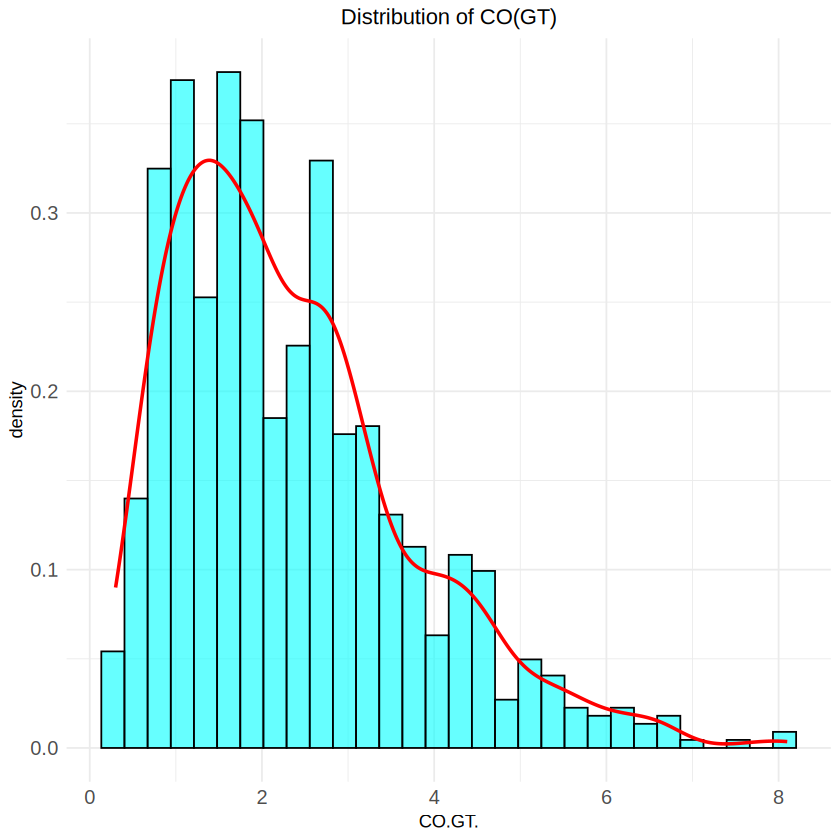

In [29]:
ggplot(air_quality, aes(x = `CO.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of CO(GT)") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**:
- Nhìn vào biểu đồ, ta thấy phân phối của biến `CO.GT.` bị lệch phải.

Ta thử sử dụng log-transform nó.

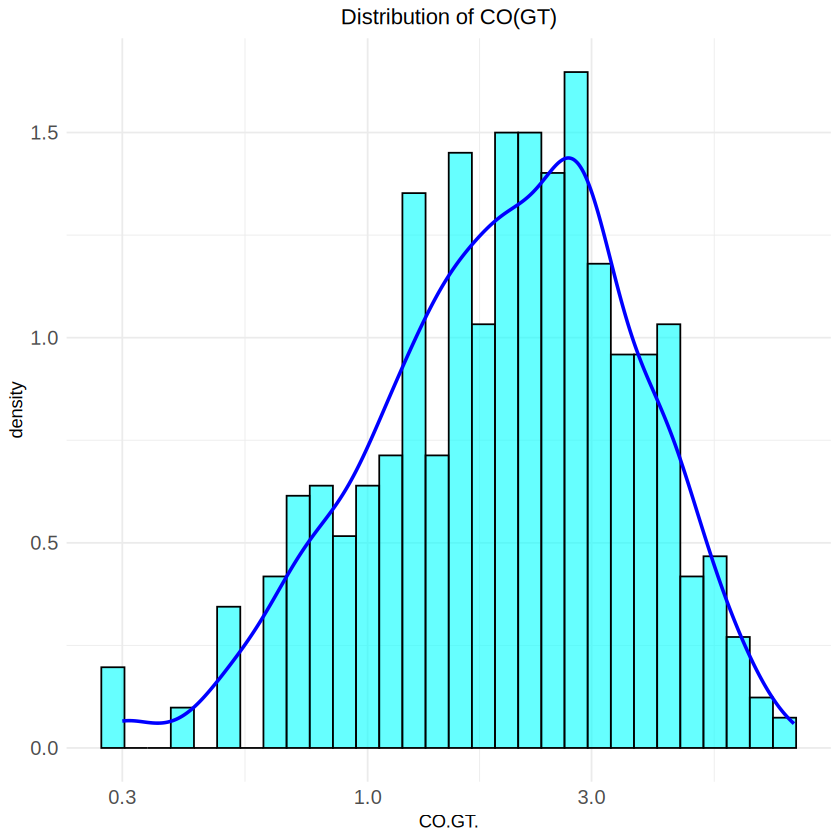

In [30]:
ggplot(air_quality, aes(x = `CO.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of CO(GT)") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.262626262626263"


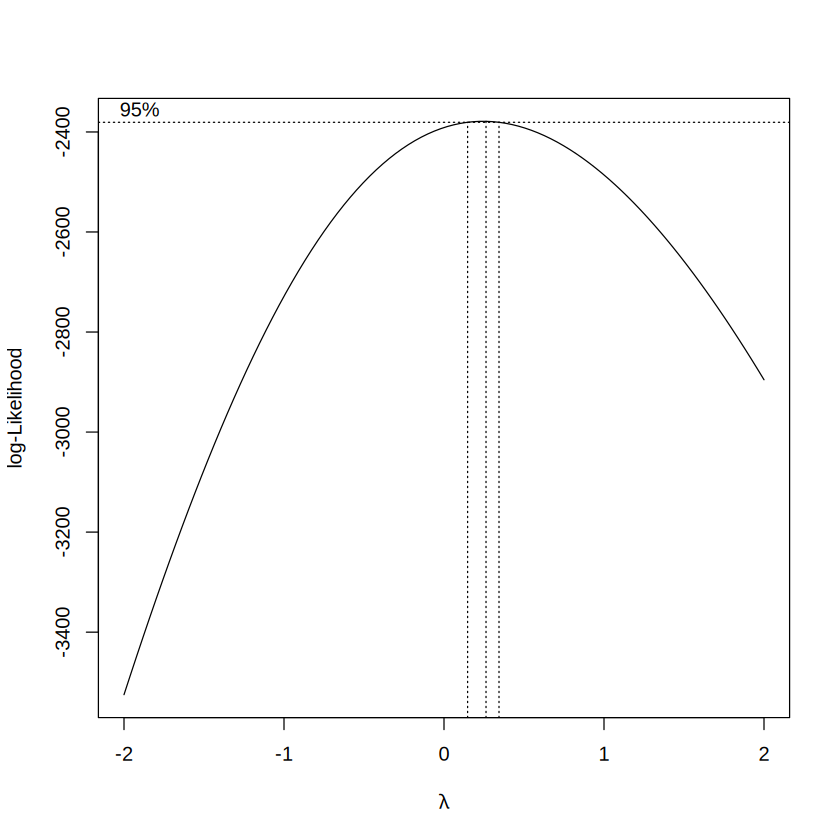

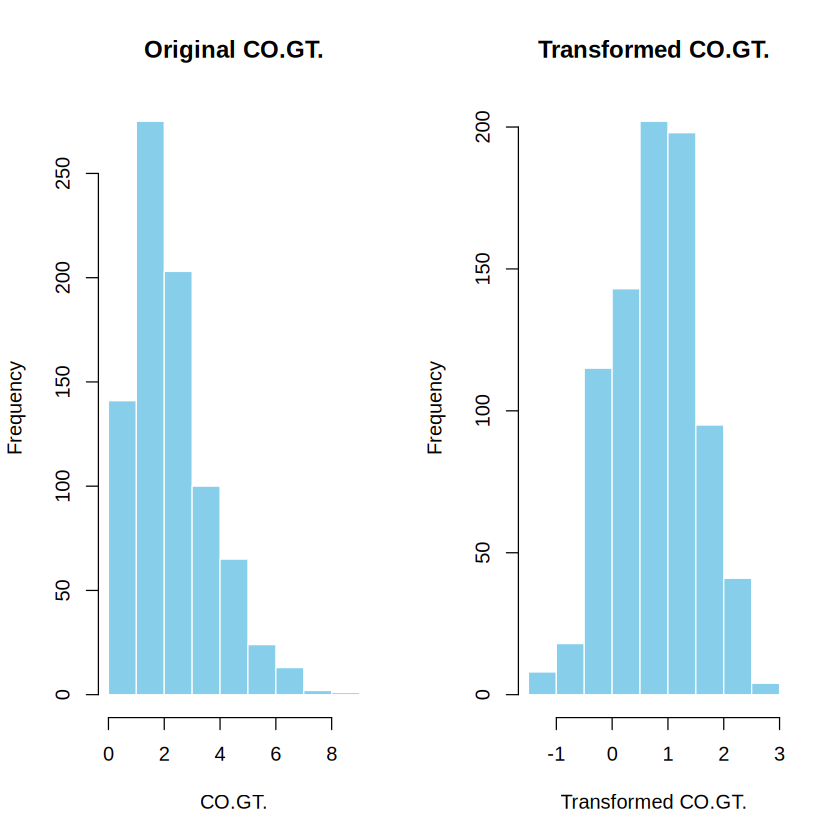

In [31]:
response_variable <- air_quality$`CO.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original CO.GT.", xlab = "CO.GT.", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed CO.GT.", xlab = "Transformed CO.GT.", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

Ta có được giá trị lambda tối ưu là 0.33 và sử dụng giá trị này để biến đổi biến `CO(GT)`. Biểu đồ histogram phía bên dưới thể hiện phân phối của biến này trước và sau khi biến đổi. Dễ dàng thấy được, sau khi biến đổi, biến này đã tương đối chuẩn hơn.

Ta thực hiện gán giá trị đã được biến đổi vào dataframe.

In [32]:
air_quality$`CO.GT.` <- transformed_response

### 2. PT08.S1(CO): Sensor response for CO

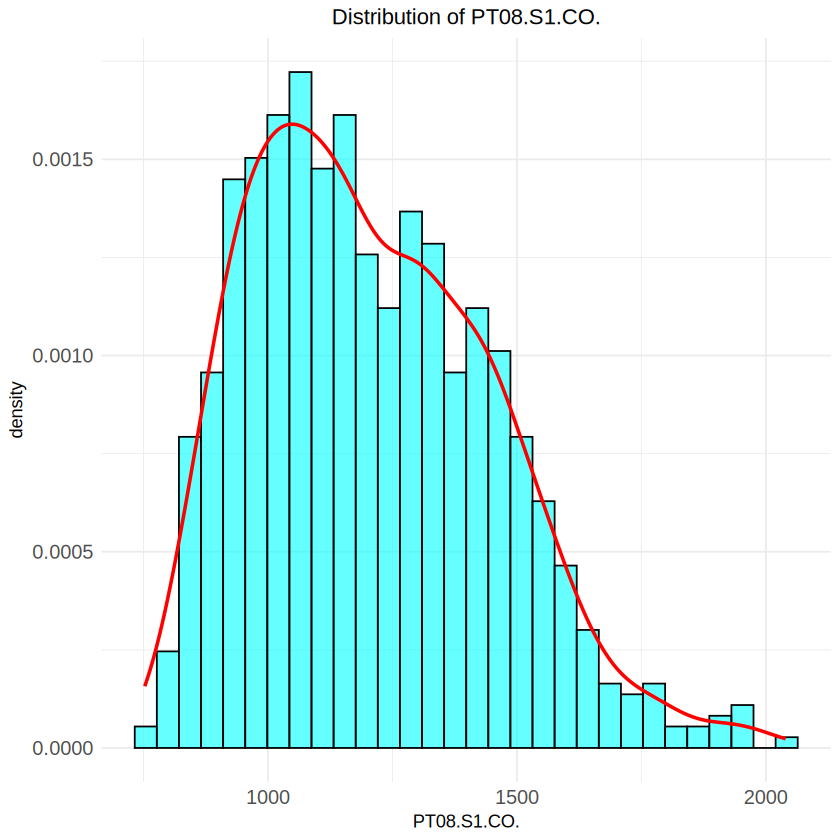

In [33]:
ggplot(air_quality, aes(x = `PT08.S1.CO.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S1.CO.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

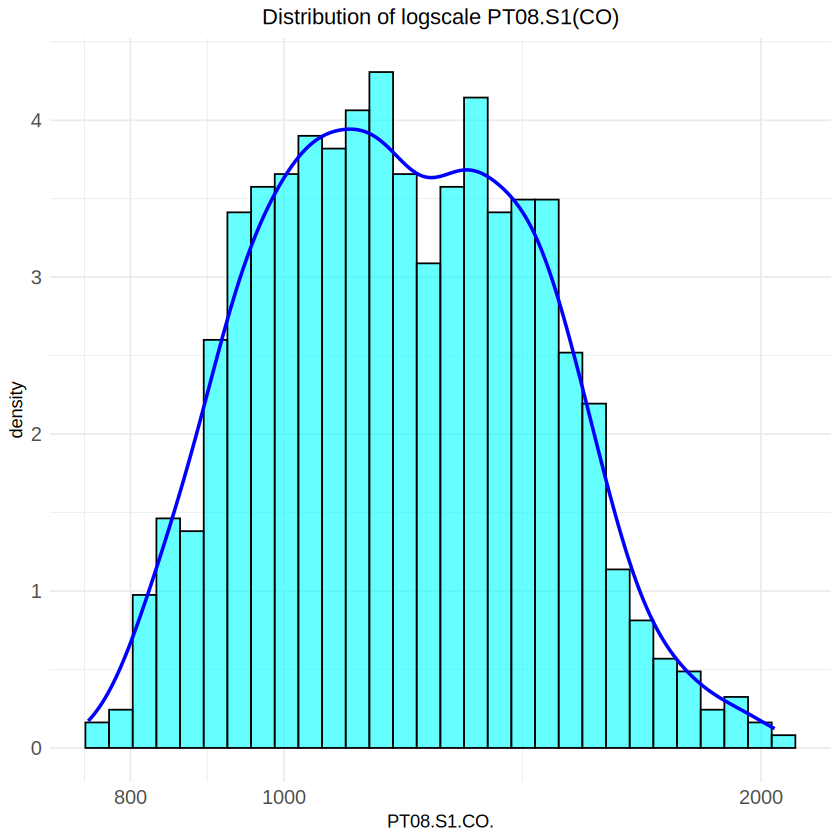

In [34]:
ggplot(air_quality, aes(x = `PT08.S1.CO.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S1(CO)") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  -0.303030303030303"


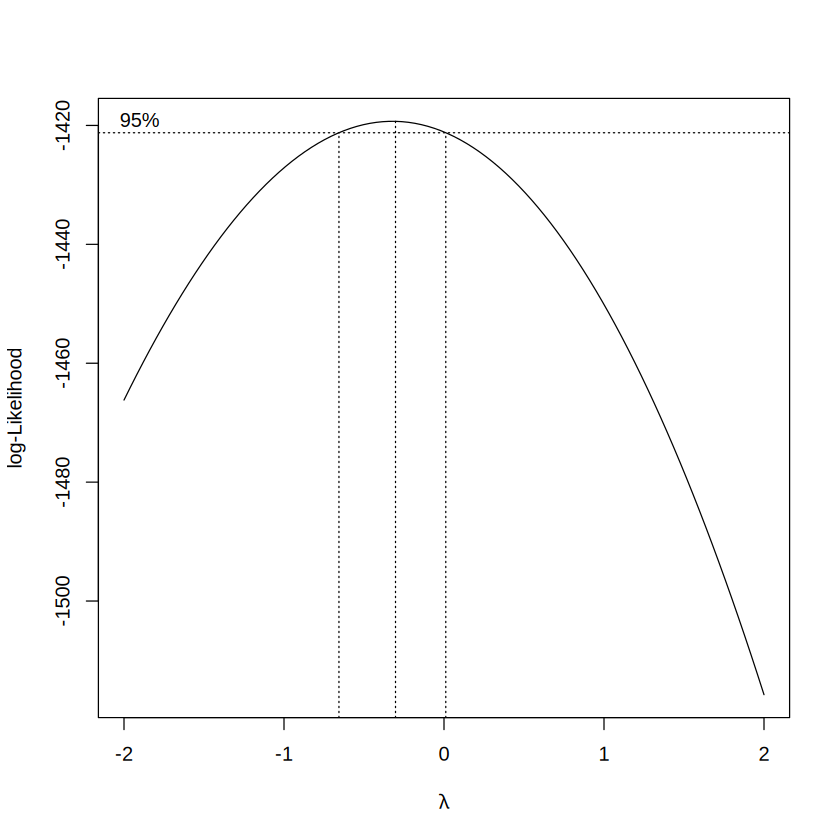

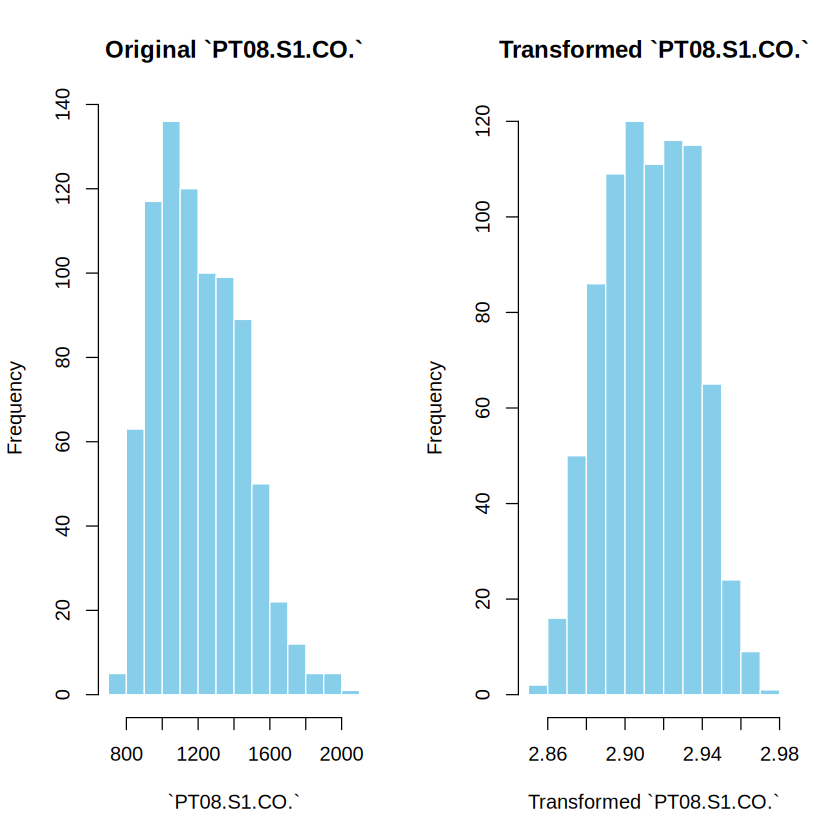

In [35]:
response_variable <- air_quality$`PT08.S1.CO.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S1.CO.`", xlab = "`PT08.S1.CO.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S1.CO.`", xlab = "Transformed `PT08.S1.CO.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [36]:
air_quality$`PT08.S1.CO.` <- transformed_response

### 3. NMHC(GT): Non-methane hydrocarbons concentration (μg/m³)

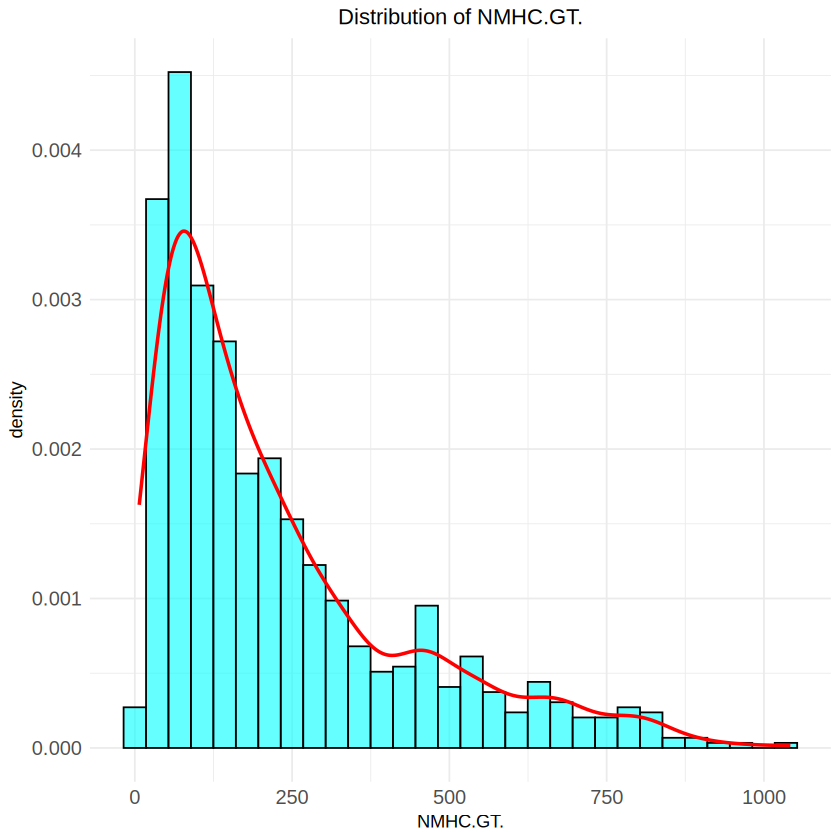

In [37]:
ggplot(air_quality, aes(x = `NMHC.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of NMHC.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

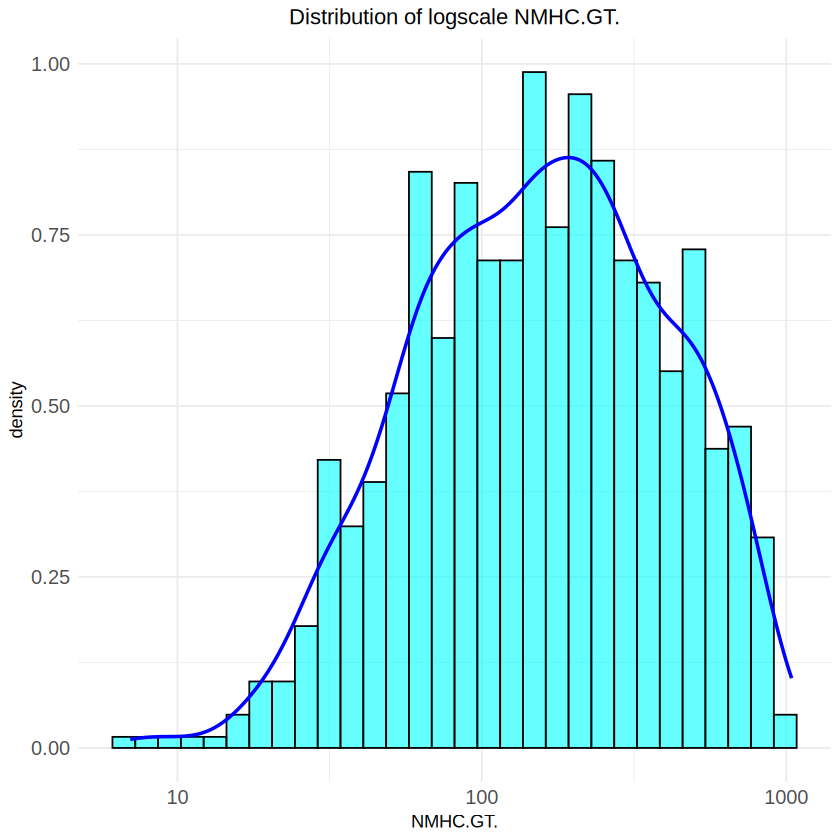

In [38]:
ggplot(air_quality, aes(x = `NMHC.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale NMHC.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.101010101010101"


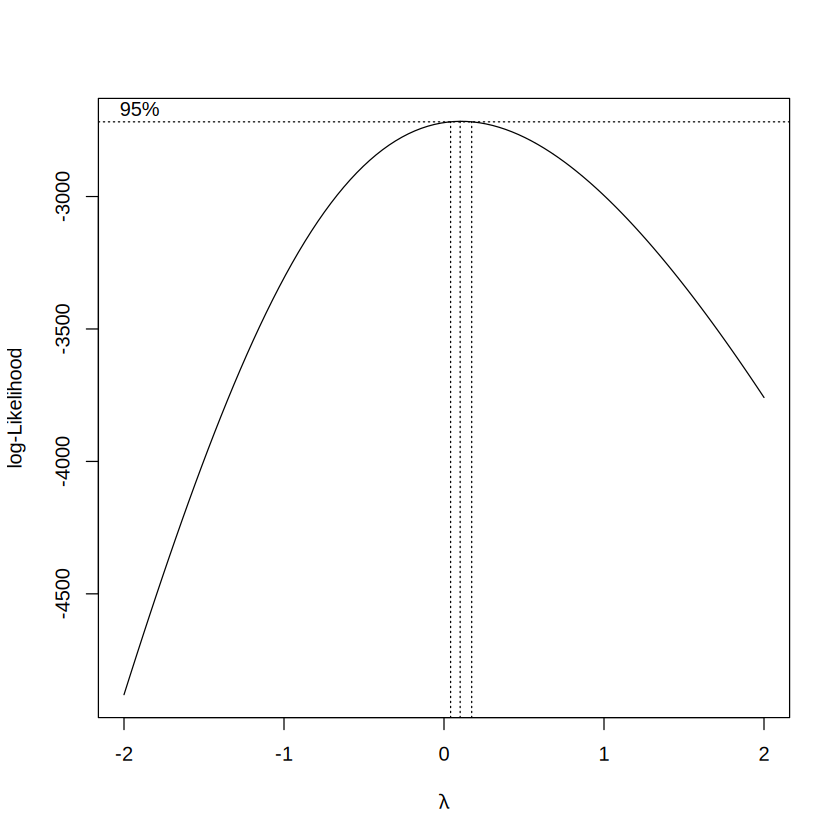

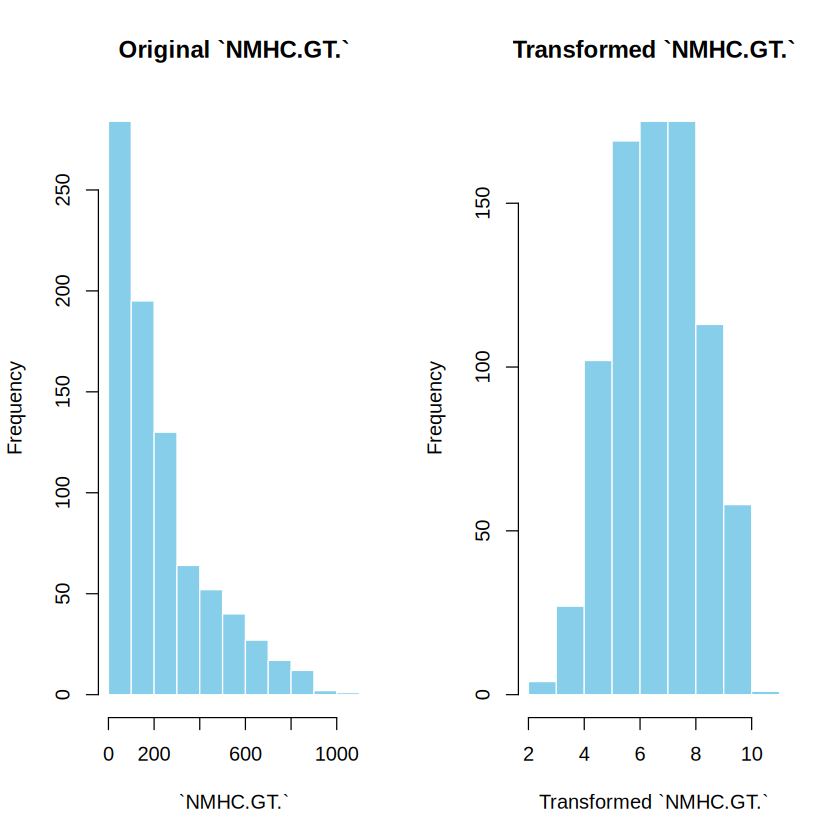

In [39]:
response_variable <- air_quality$`NMHC.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `NMHC.GT.`", xlab = "`NMHC.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `NMHC.GT.`", xlab = "Transformed `NMHC.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [40]:
air_quality$`NMHC.GT.` <- transformed_response

### 4. C6H6(GT): Benzene concentration (μg/m³)

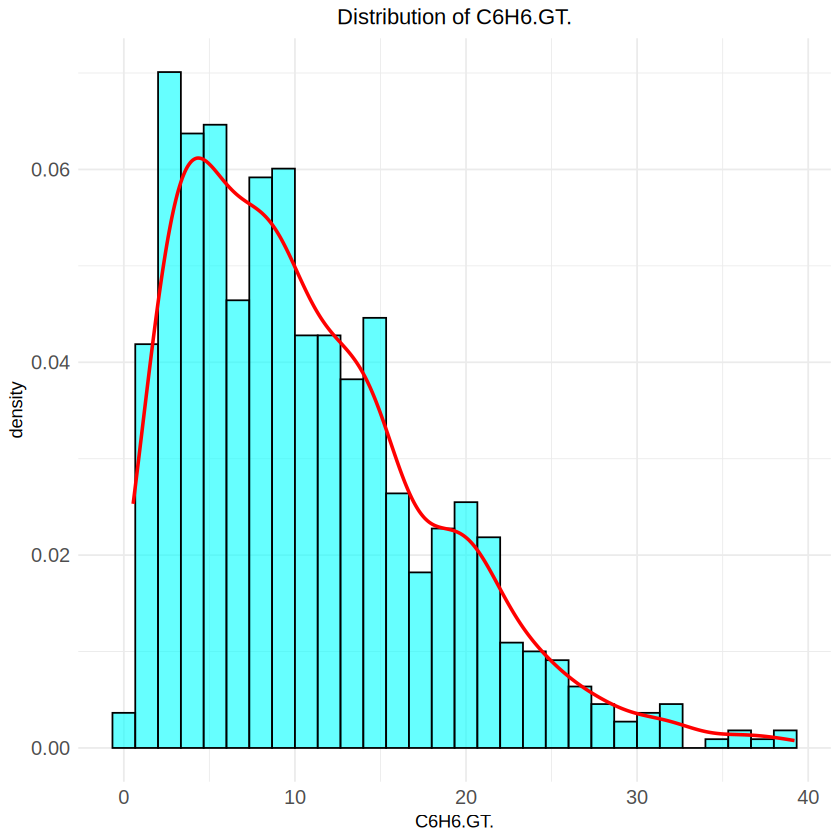

In [41]:
ggplot(air_quality, aes(x = `C6H6.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of C6H6.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

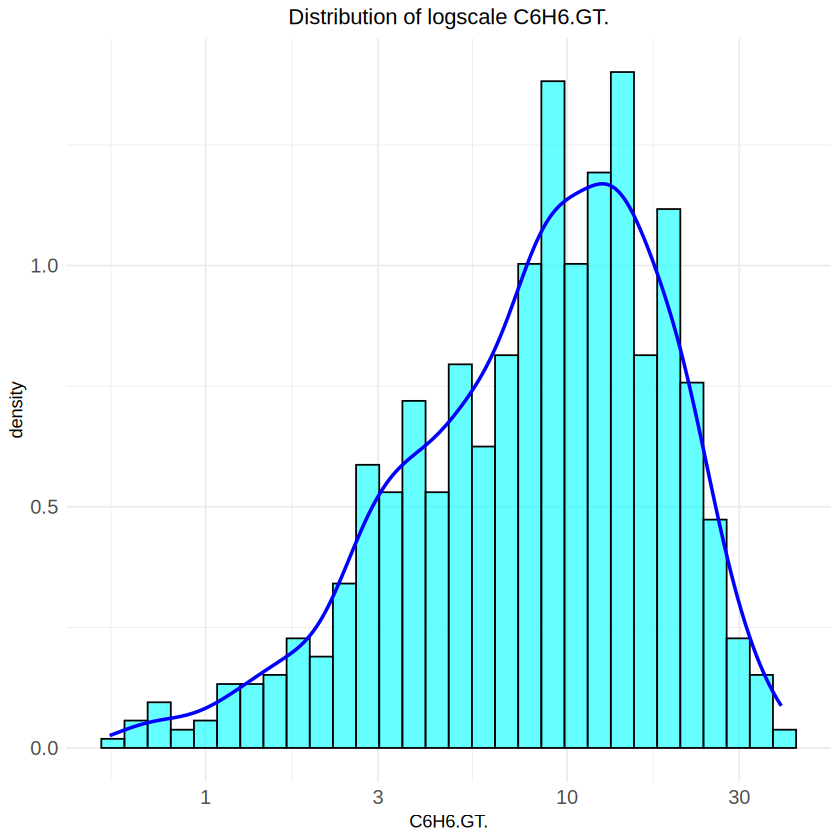

In [42]:
ggplot(air_quality, aes(x = `C6H6.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale C6H6.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.343434343434343"


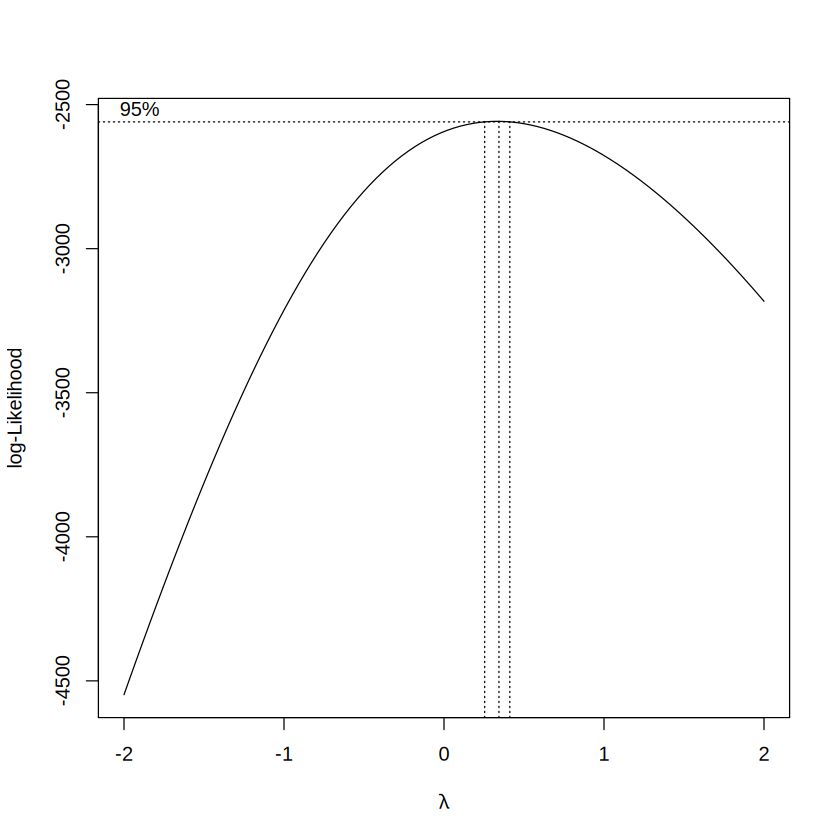

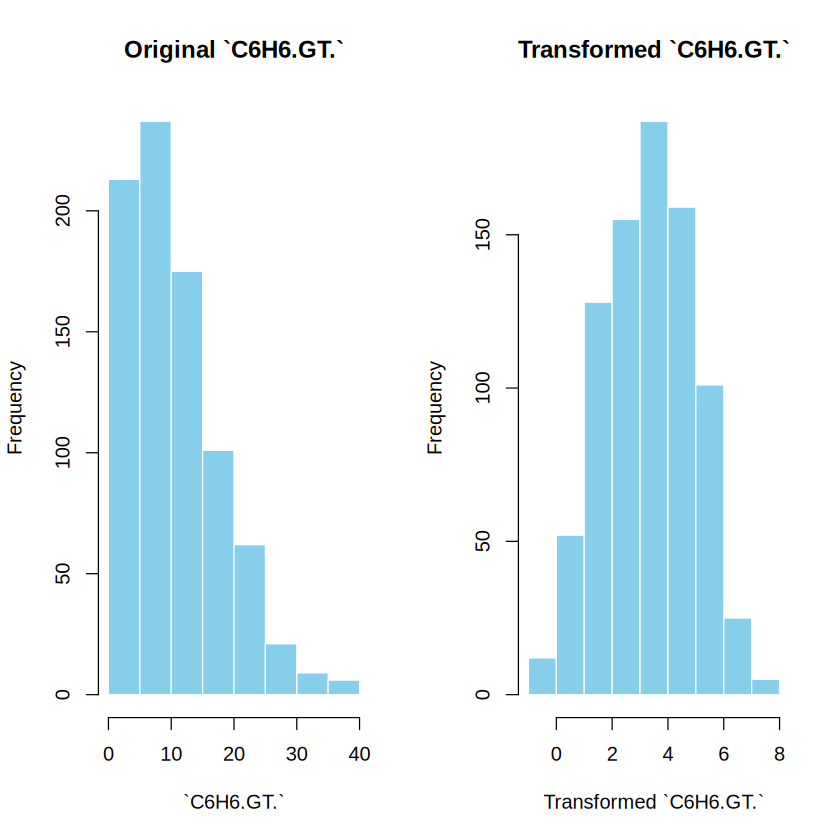

In [43]:
response_variable <- air_quality$`C6H6.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `C6H6.GT.`", xlab = "`C6H6.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `C6H6.GT.`", xlab = "Transformed `C6H6.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [44]:
air_quality$`C6H6.GT.` <- transformed_response

### 5. PT08.S2(NMHC): Sensor response for NMHC

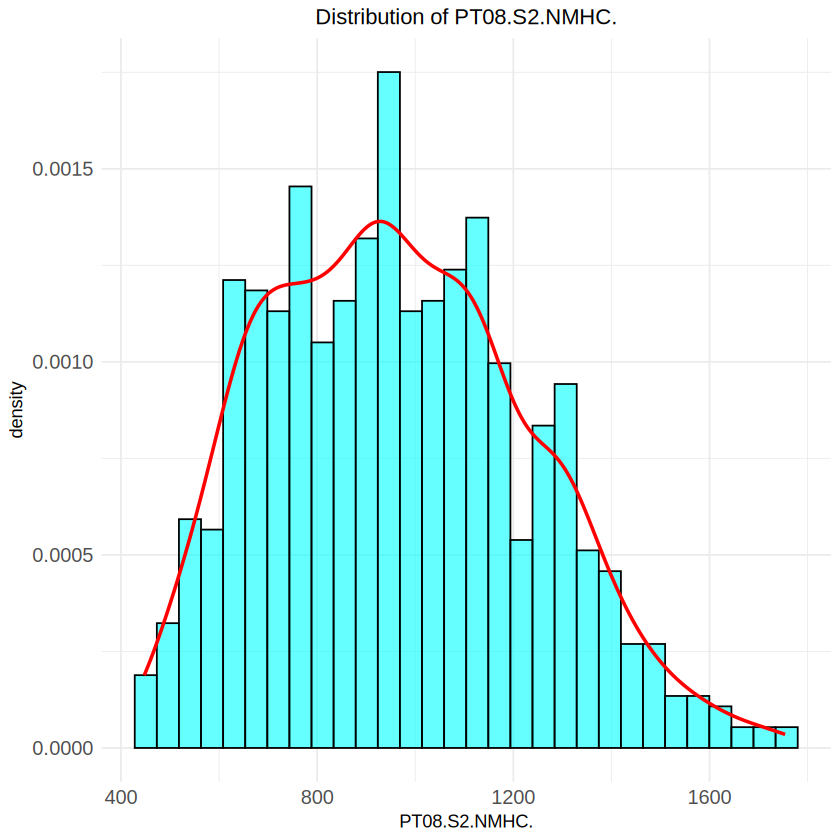

In [45]:
ggplot(air_quality, aes(x = `PT08.S2.NMHC.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S2.NMHC.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

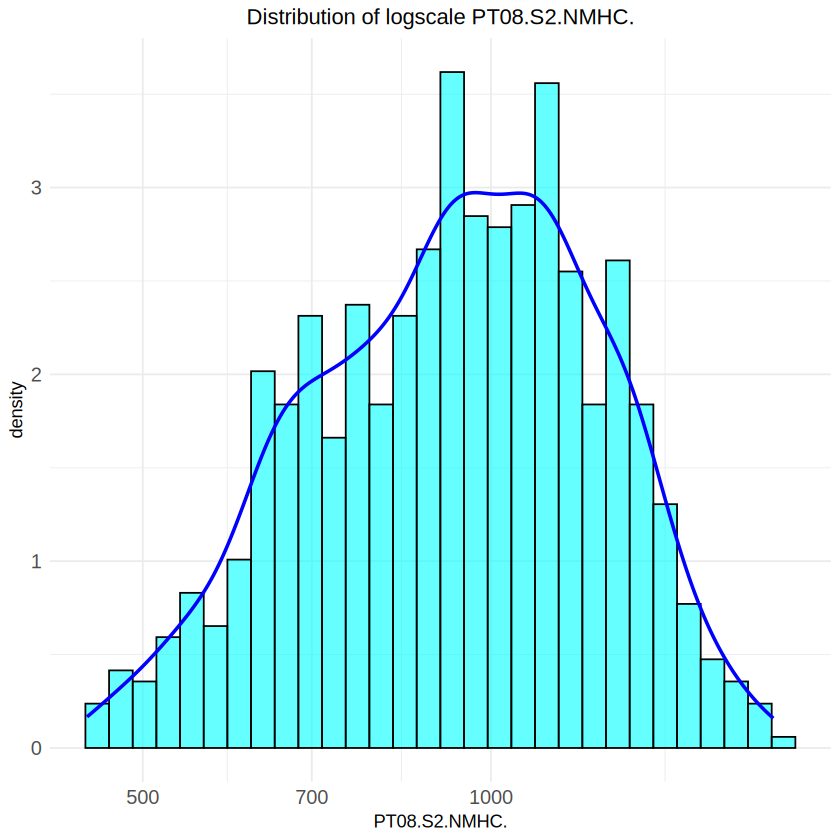

In [46]:
ggplot(air_quality, aes(x = `PT08.S2.NMHC.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S2.NMHC.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.383838383838384"


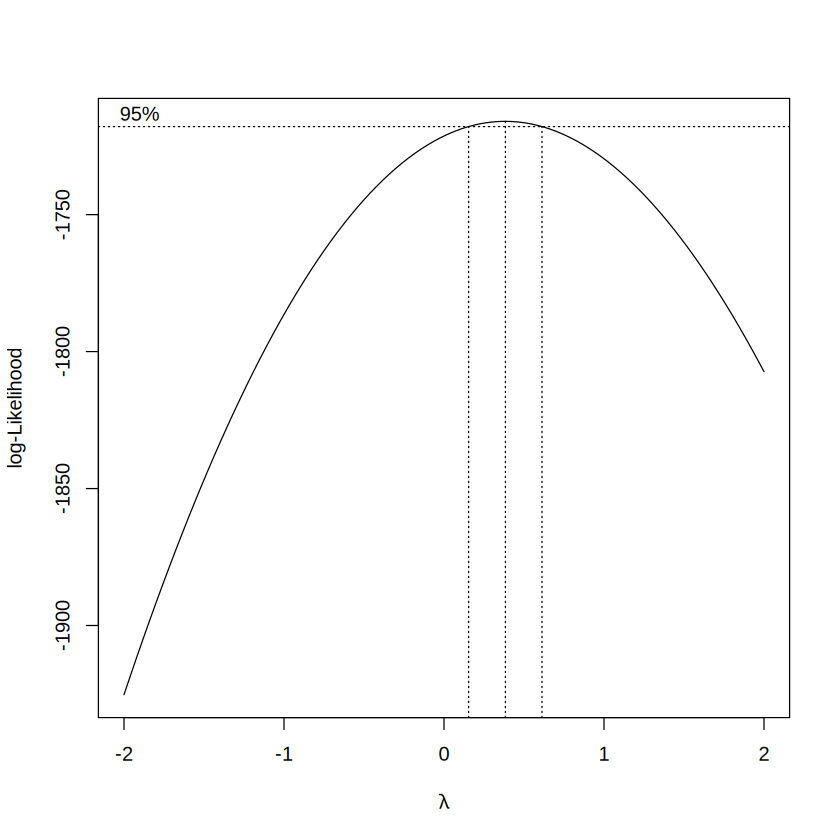

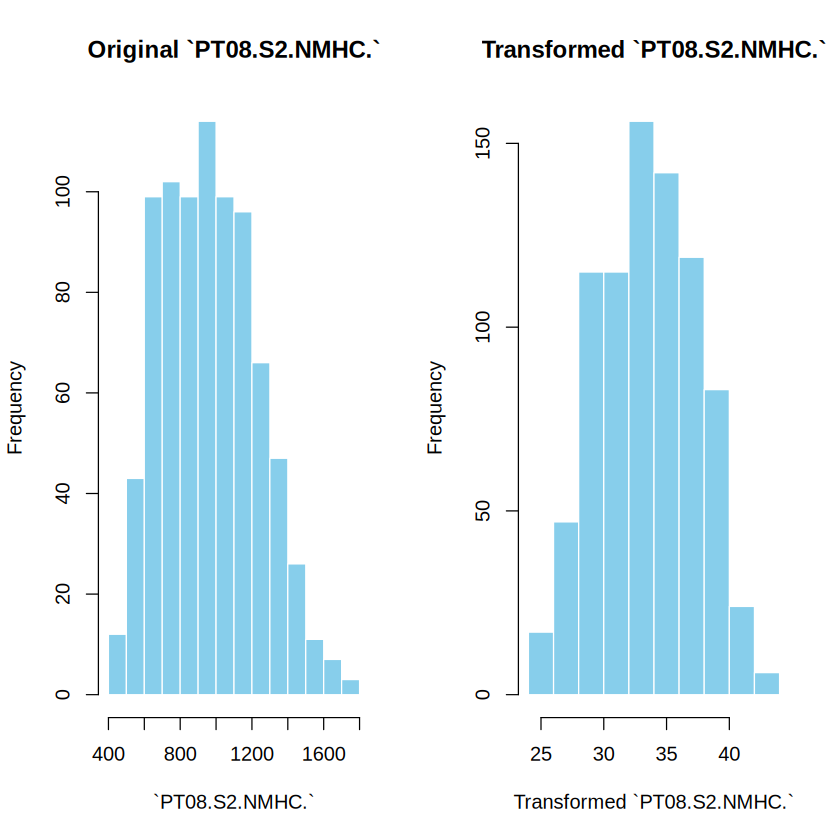

In [47]:
response_variable <- air_quality$`PT08.S2.NMHC.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S2.NMHC.`", xlab = "`PT08.S2.NMHC.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S2.NMHC.`", xlab = "Transformed `PT08.S2.NMHC.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [48]:
air_quality$`PT08.S2.NMHC.` <- transformed_response

### 6. NOx(GT): Nitrogen oxides concentration (ppb)

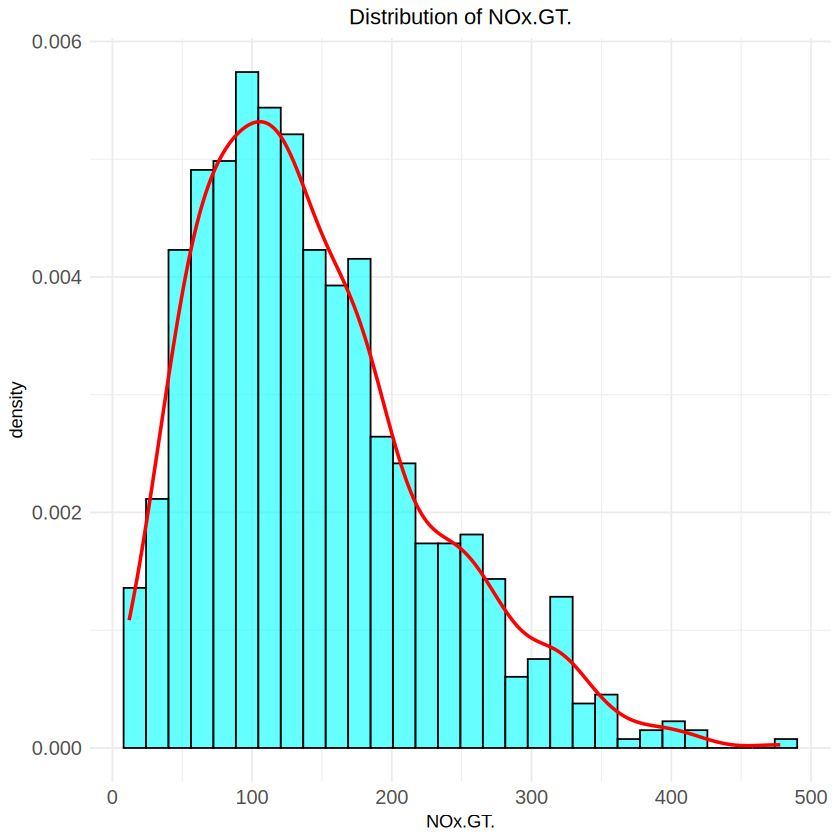

In [49]:
ggplot(air_quality, aes(x = `NOx.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of NOx.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

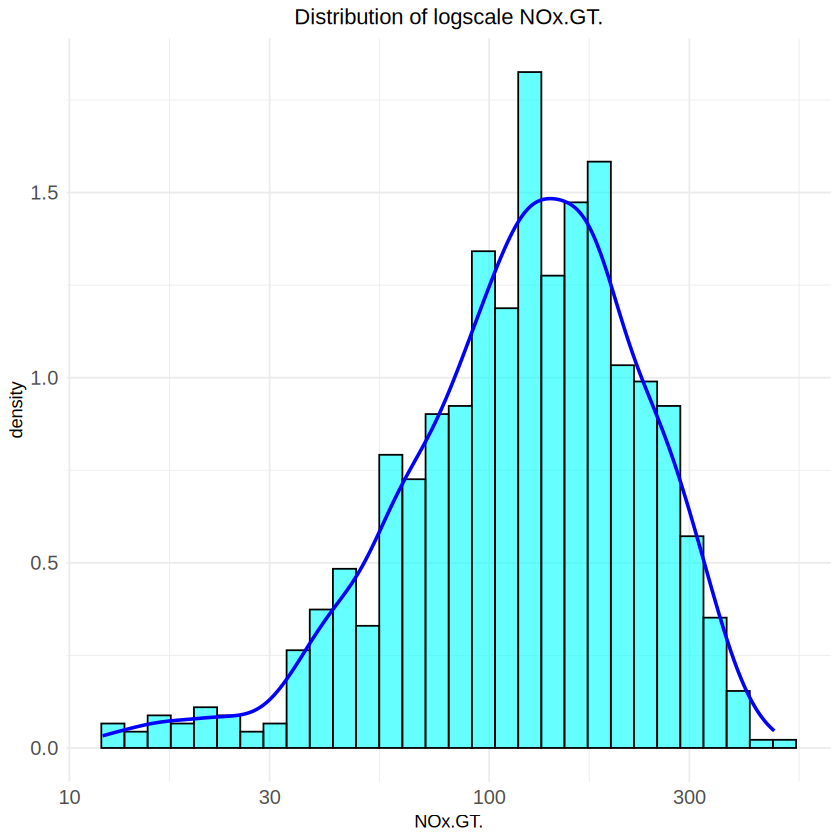

In [50]:
ggplot(air_quality, aes(x = `NOx.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale NOx.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.383838383838384"


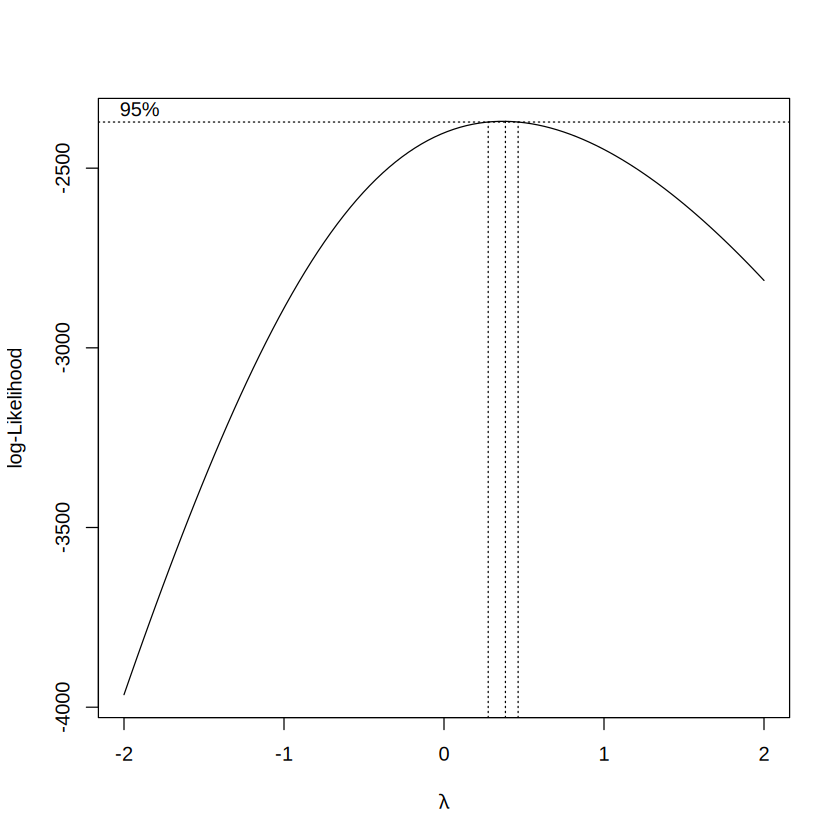

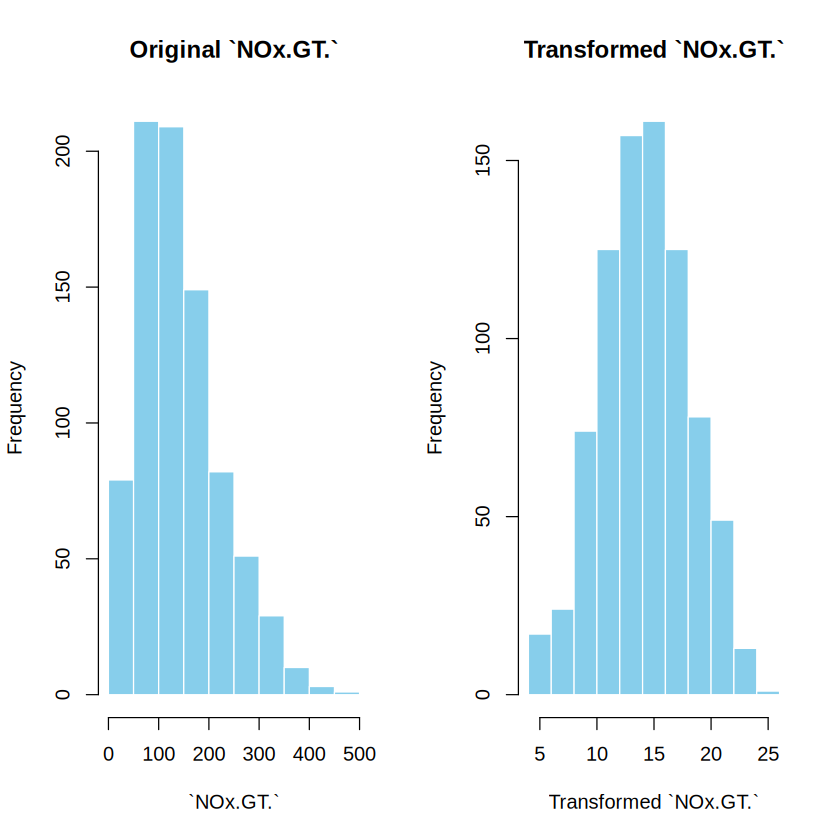

In [51]:
response_variable <- air_quality$`NOx.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `NOx.GT.`", xlab = "`NOx.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `NOx.GT.`", xlab = "Transformed `NOx.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [52]:
air_quality$`NOx.GT.` <- transformed_response

### 7. PT08.S3(NOx): Sensor response for NOx

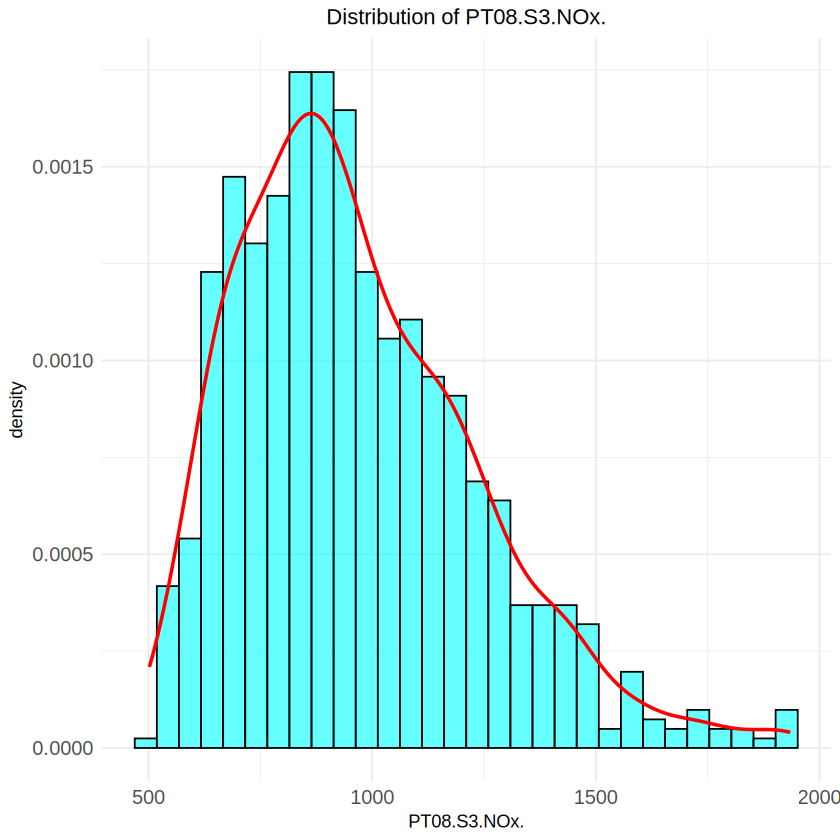

In [53]:
ggplot(air_quality, aes(x = `PT08.S3.NOx.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S3.NOx.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

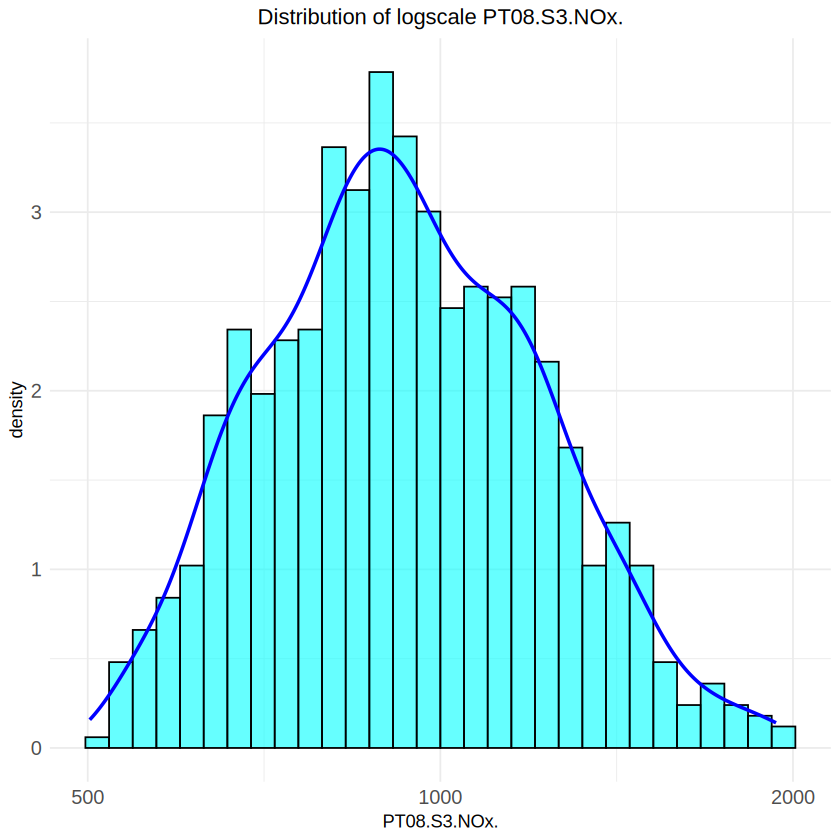

In [54]:
ggplot(air_quality, aes(x = `PT08.S3.NOx.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S3.NOx.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  -0.303030303030303"


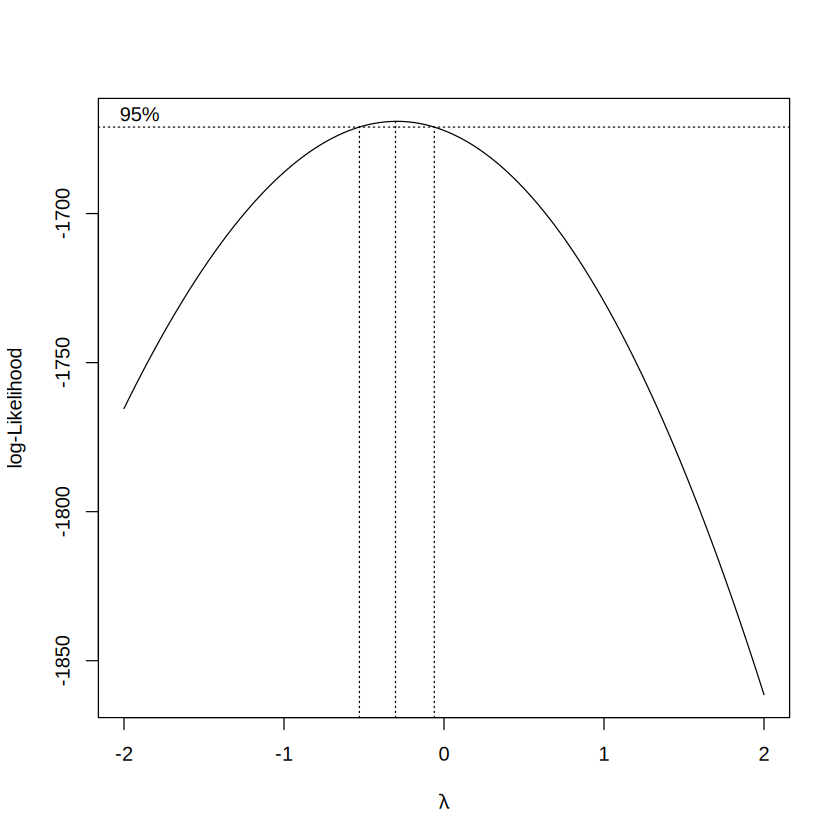

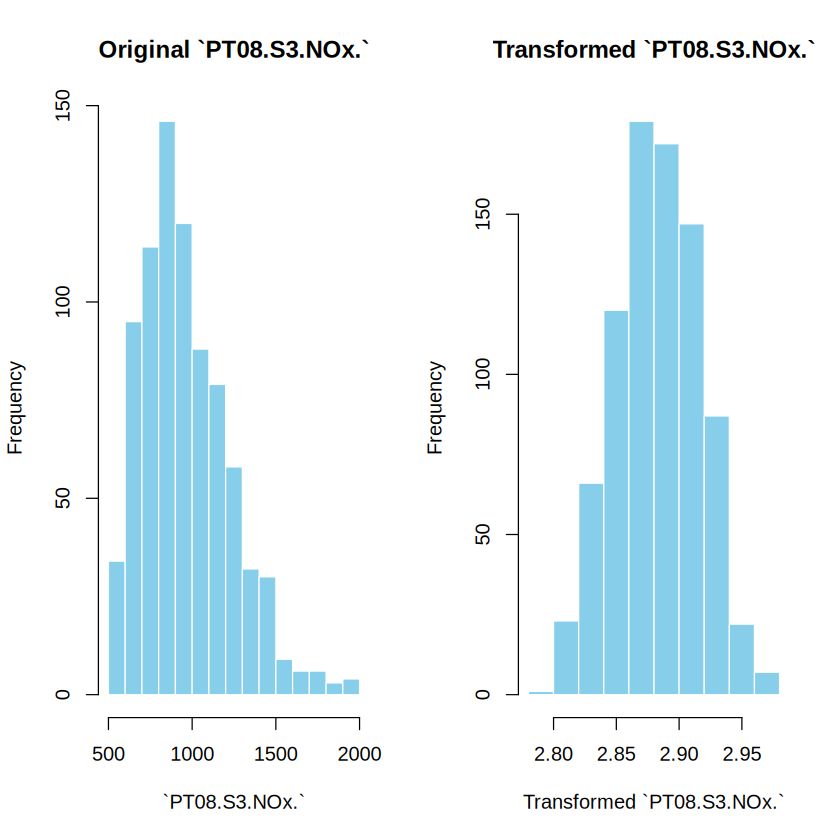

In [55]:
response_variable <- air_quality$`PT08.S3.NOx.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S3.NOx.`", xlab = "`PT08.S3.NOx.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S3.NOx.`", xlab = "Transformed `PT08.S3.NOx.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [56]:
air_quality$`PT08.S3.NOx.` <- transformed_response

### 8. NO2(GT): Nitrogen dioxide concentration (μg/m³)

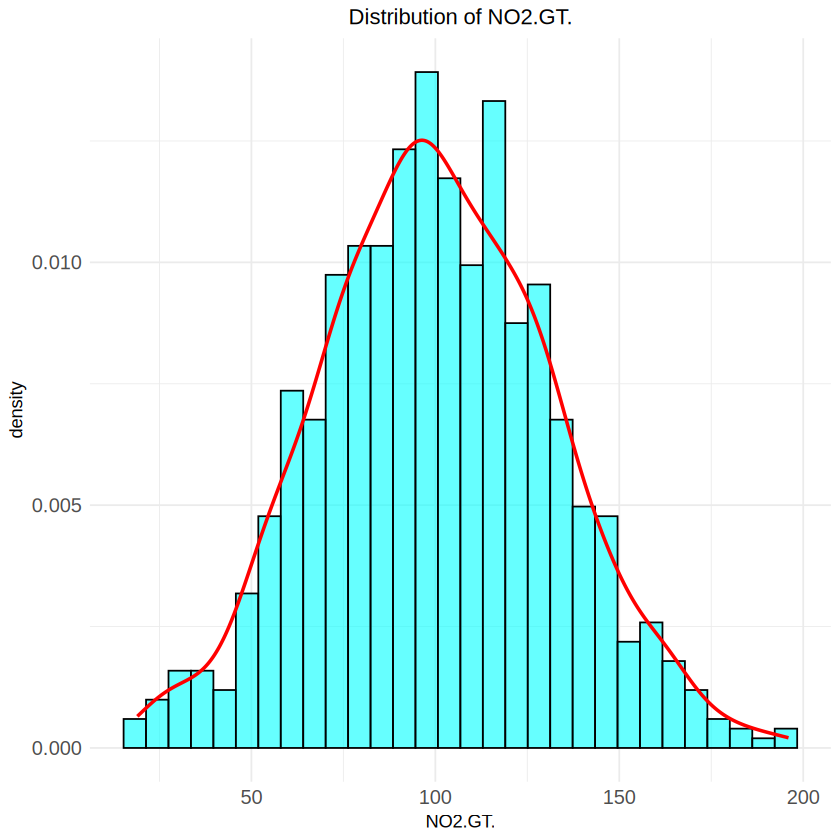

In [57]:
ggplot(air_quality, aes(x = `NO2.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of NO2.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

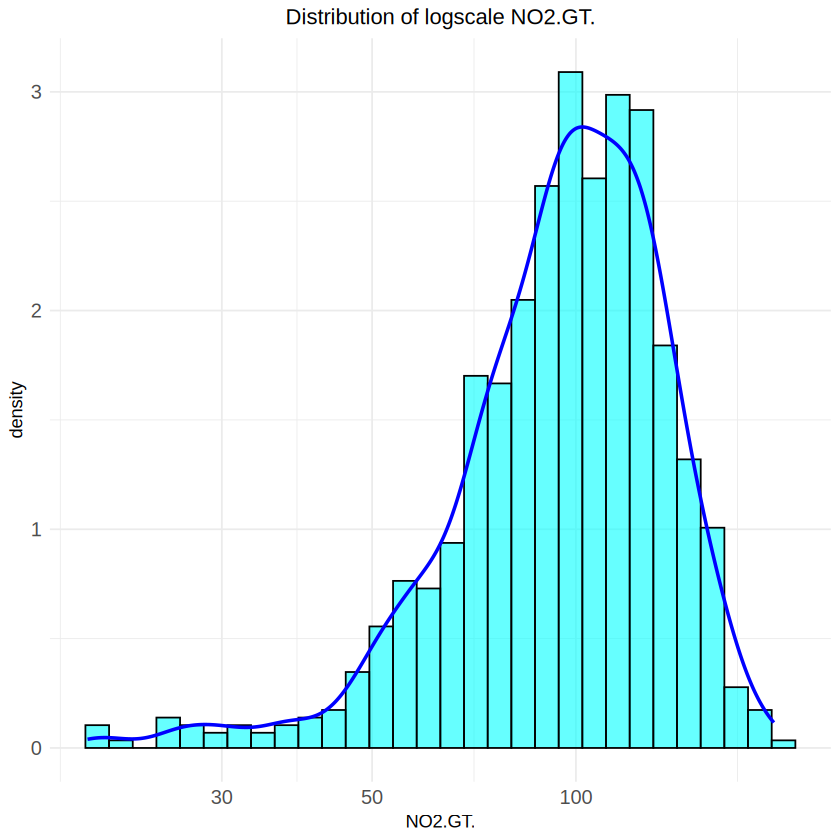

In [58]:
ggplot(air_quality, aes(x = `NO2.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale NO2.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.909090909090909"


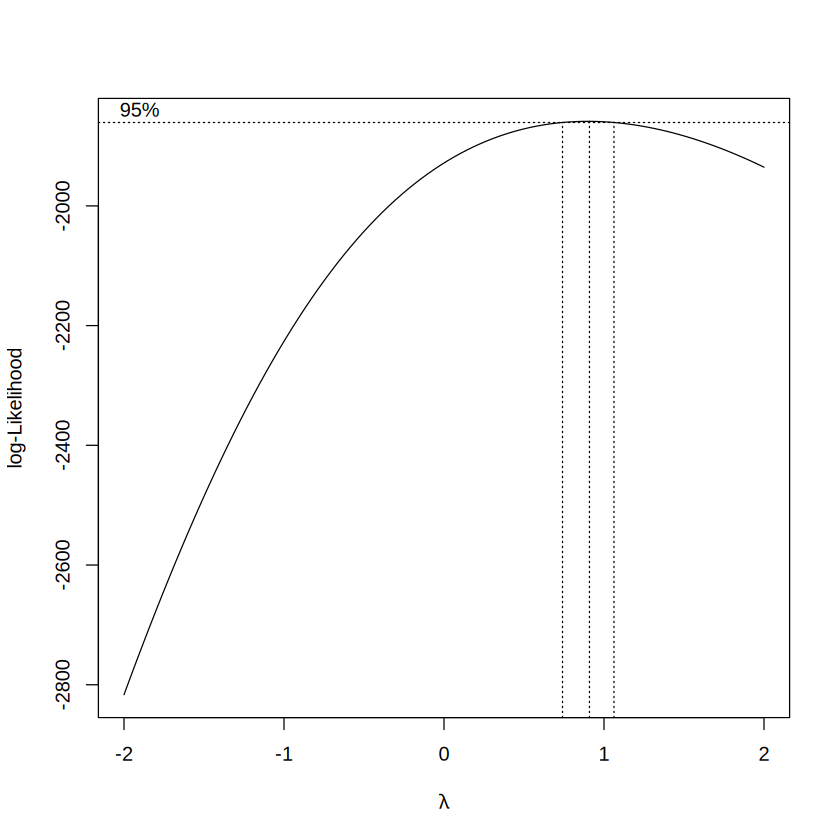

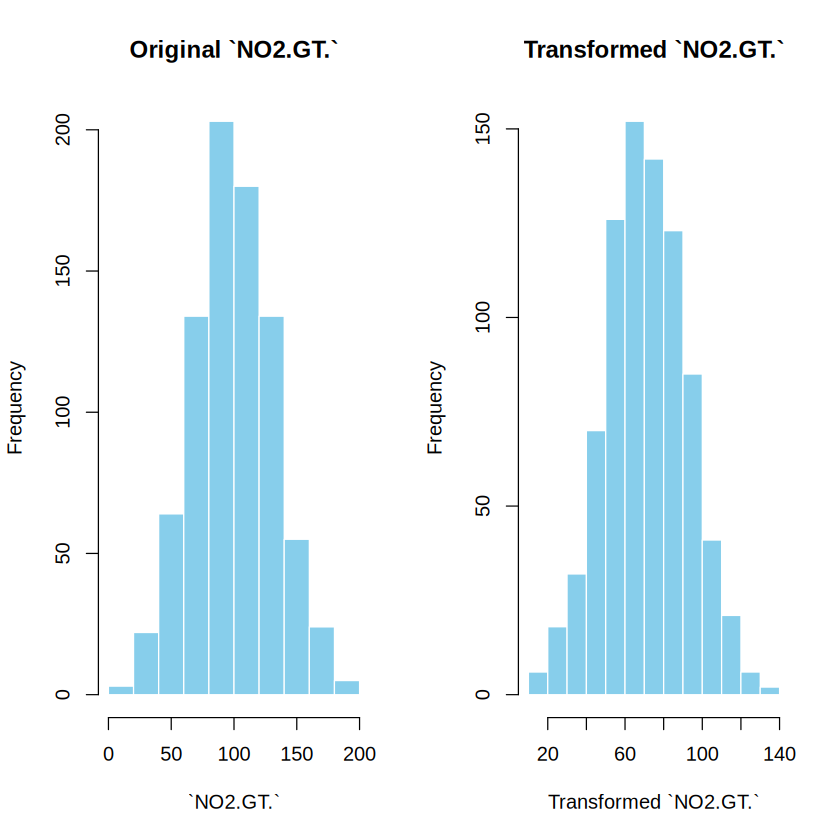

In [59]:
response_variable <- air_quality$`NO2.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `NO2.GT.`", xlab = "`NO2.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `NO2.GT.`", xlab = "Transformed `NO2.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [60]:
air_quality$`NO2.GT.` <- transformed_response

### 9. PT08.S4(NO2): Sensor response for NO2

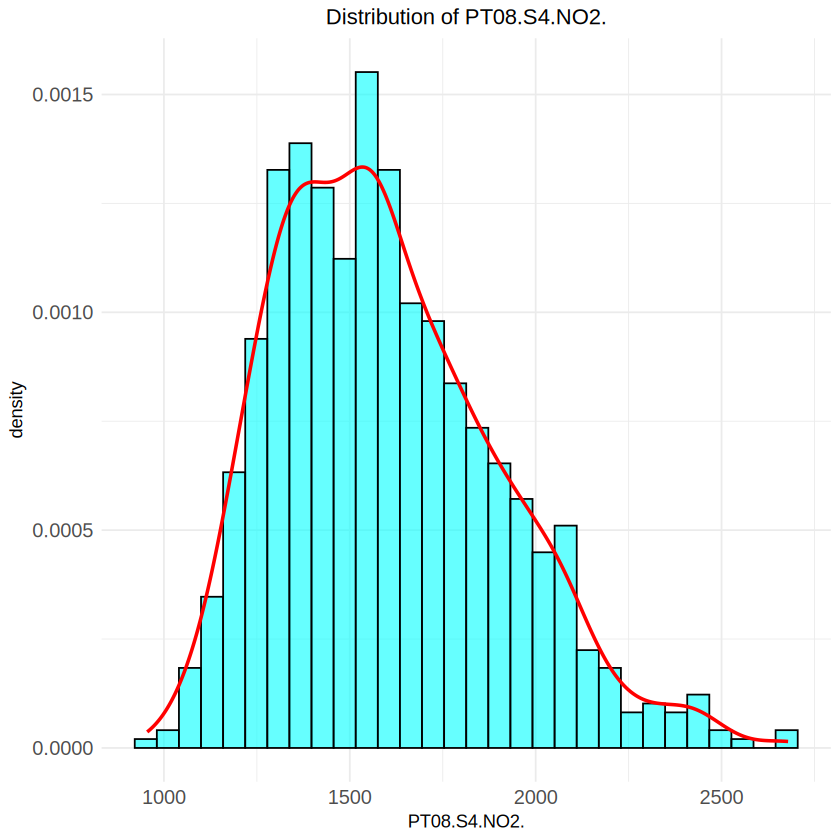

In [61]:
ggplot(air_quality, aes(x = `PT08.S4.NO2.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S4.NO2.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

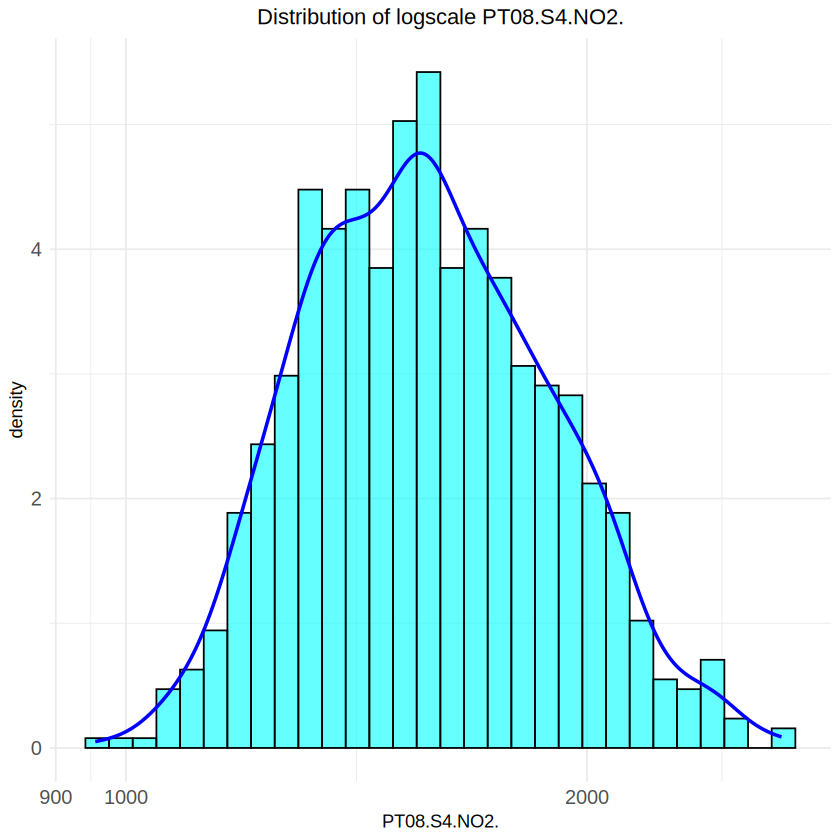

In [62]:
ggplot(air_quality, aes(x = `PT08.S4.NO2.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S4.NO2.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  -0.464646464646465"


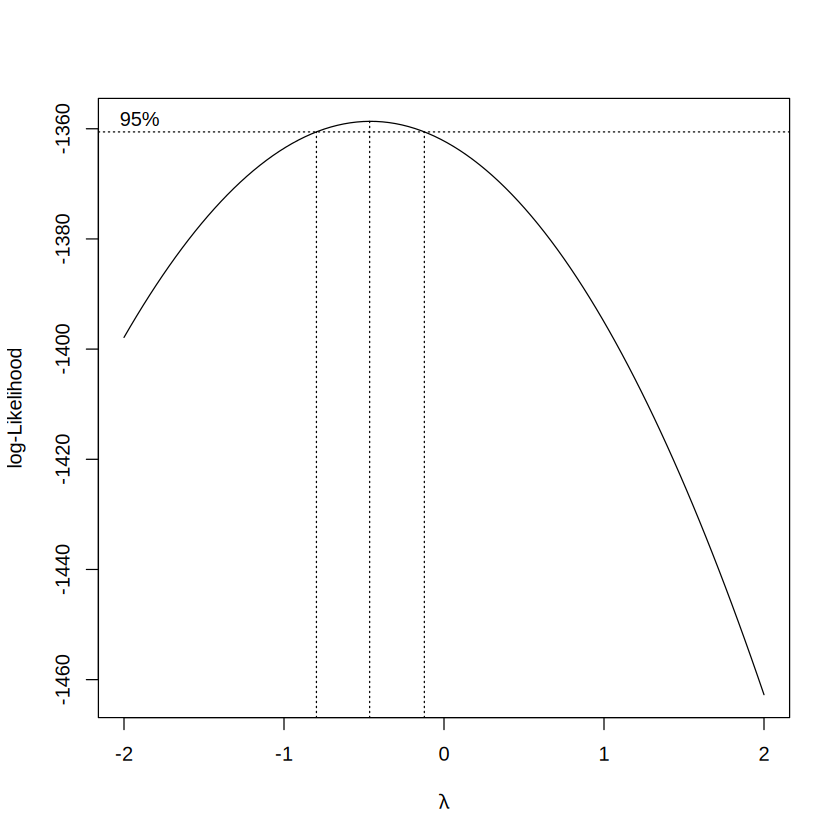

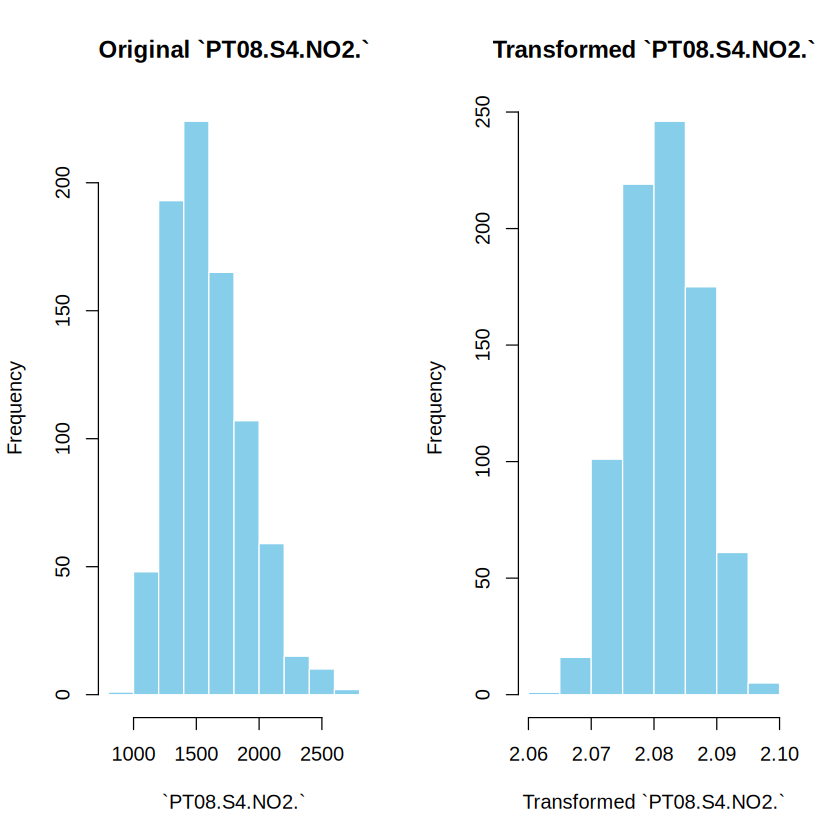

In [63]:
response_variable <- air_quality$`PT08.S4.NO2.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S4.NO2.`", xlab = "`PT08.S4.NO2.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S4.NO2.`", xlab = "Transformed `PT08.S4.NO2.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [64]:
air_quality$`PT08.S4.NO2.` <- transformed_response

### 10. PT08.S5(O3): Sensor response for ozone

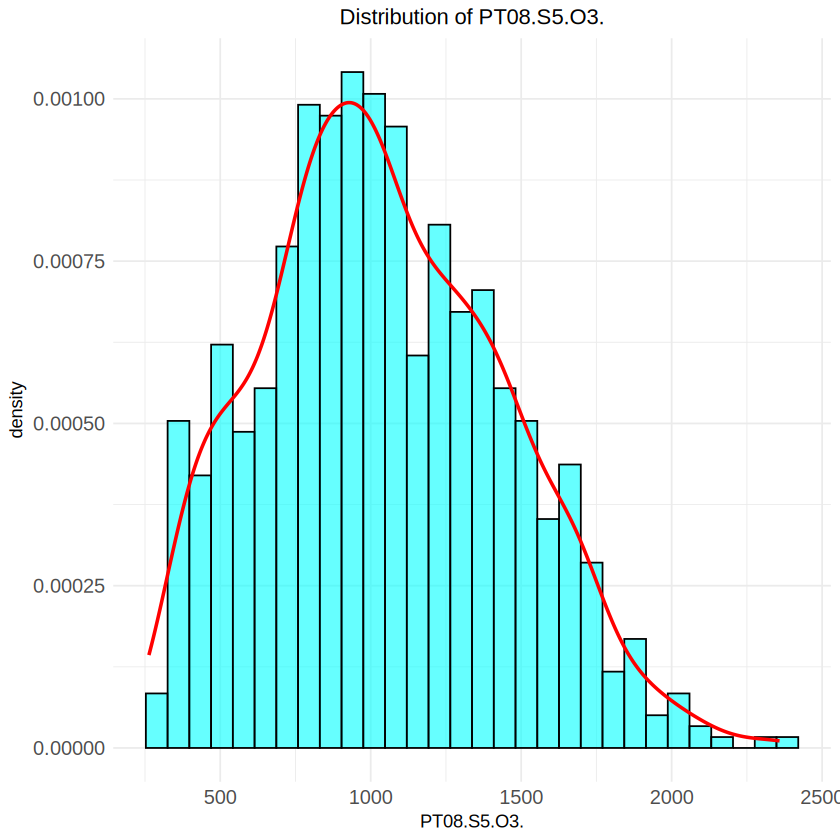

In [65]:
ggplot(air_quality, aes(x = `PT08.S5.O3.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S5.O3.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

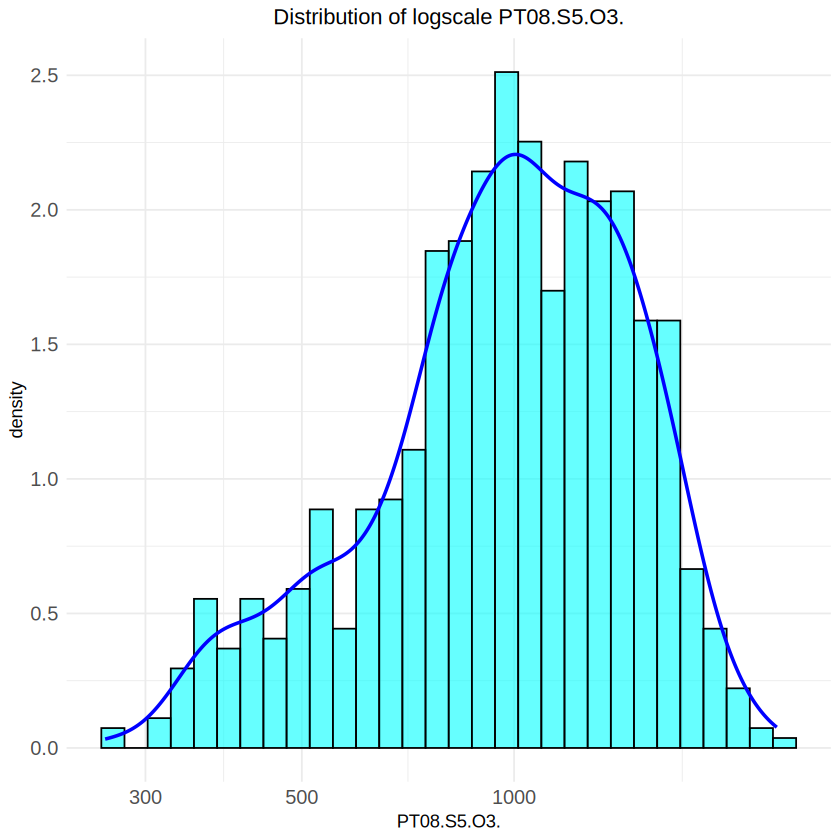

In [66]:
ggplot(air_quality, aes(x = `PT08.S5.O3.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S5.O3.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.585858585858586"


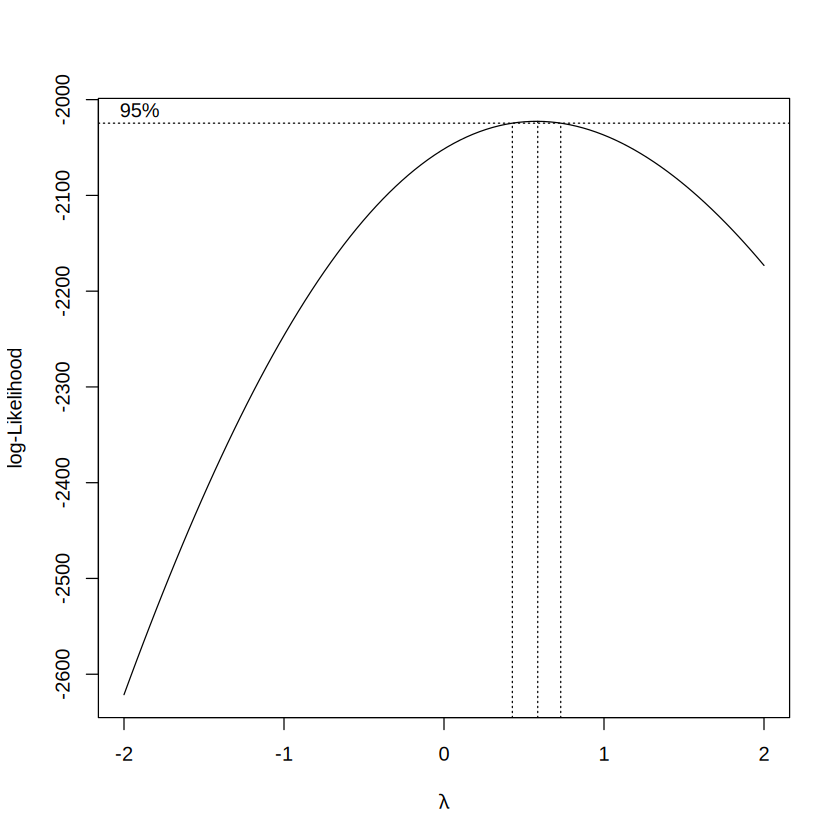

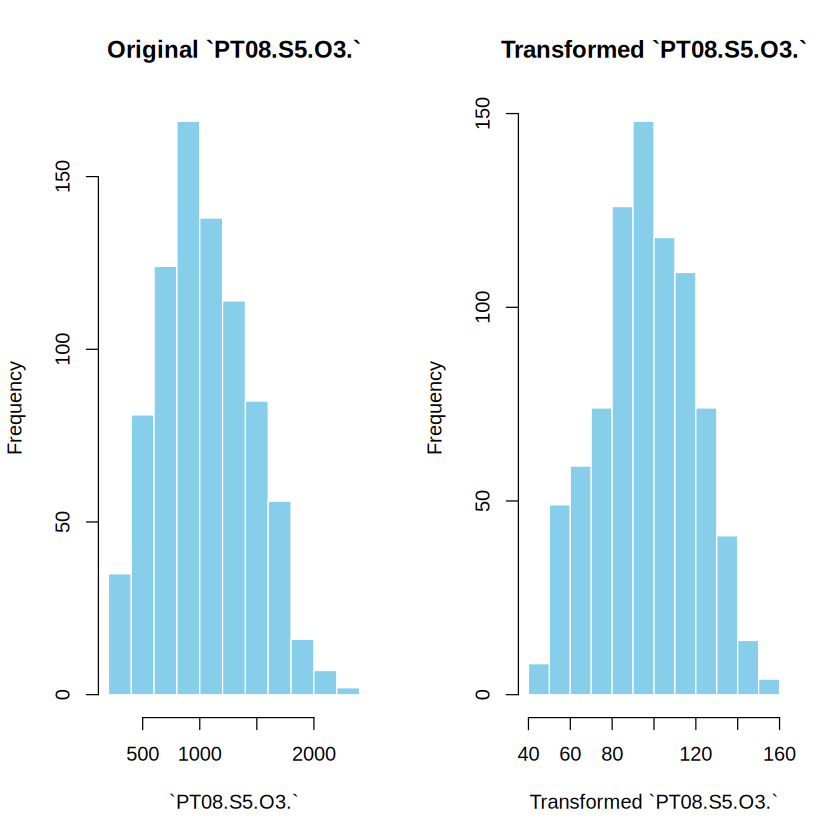

In [67]:
response_variable <- air_quality$`PT08.S5.O3.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S5.O3.`", xlab = "`PT08.S5.O3.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S5.O3.`", xlab = "Transformed `PT08.S5.O3.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [68]:
air_quality$`PT08.S5.O3.` <- transformed_response

### 11. T: Temperature (°C)

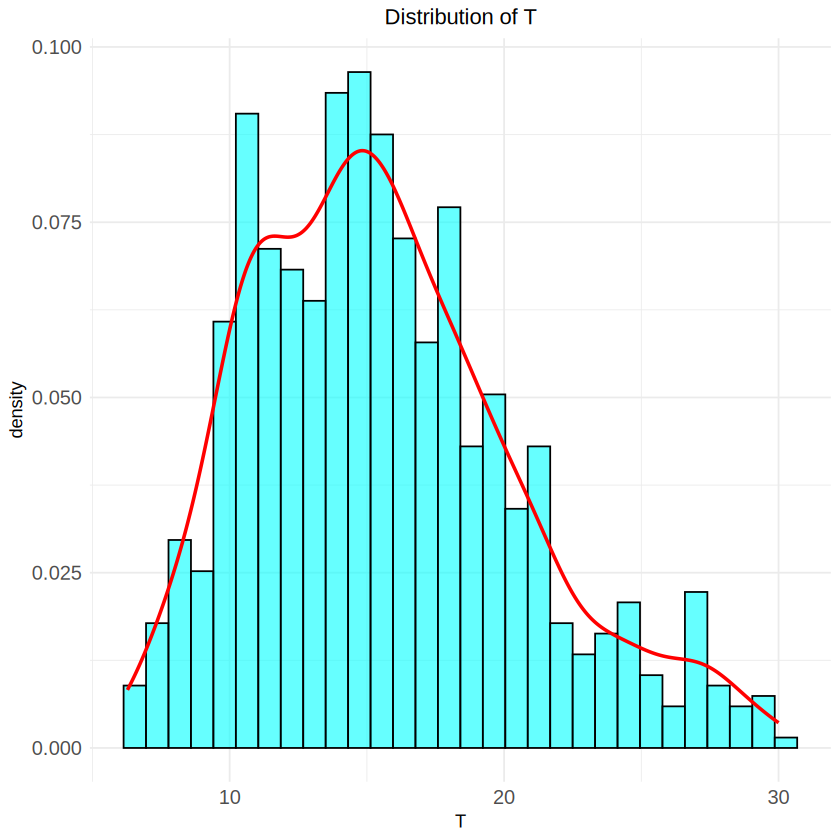

In [69]:
ggplot(air_quality, aes(x = `T`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of T") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

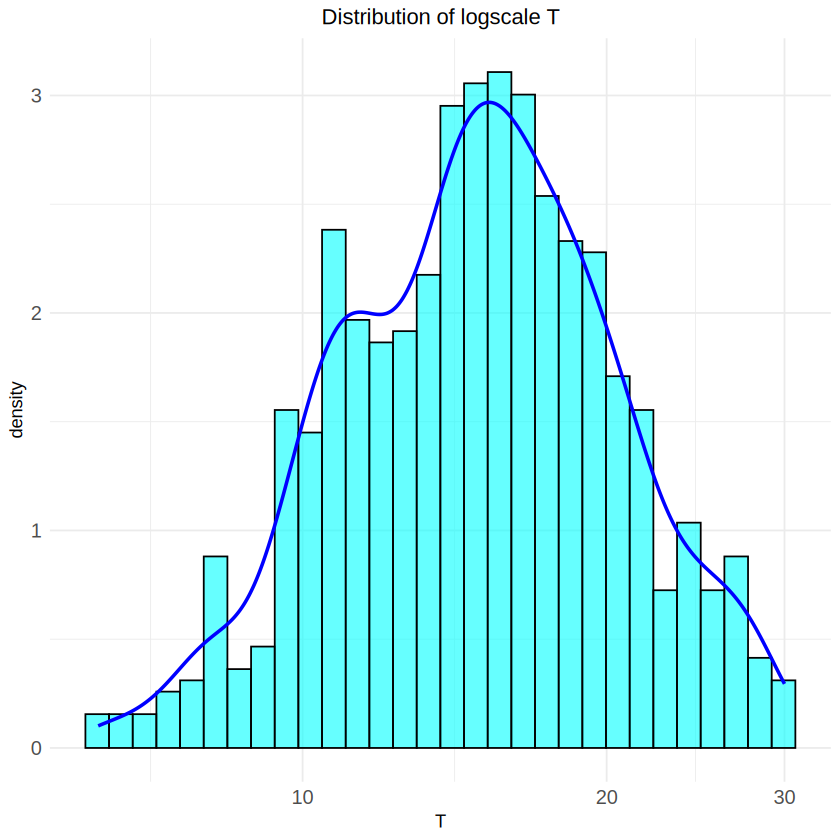

In [70]:
ggplot(air_quality, aes(x = `T`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale T") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.141414141414141"


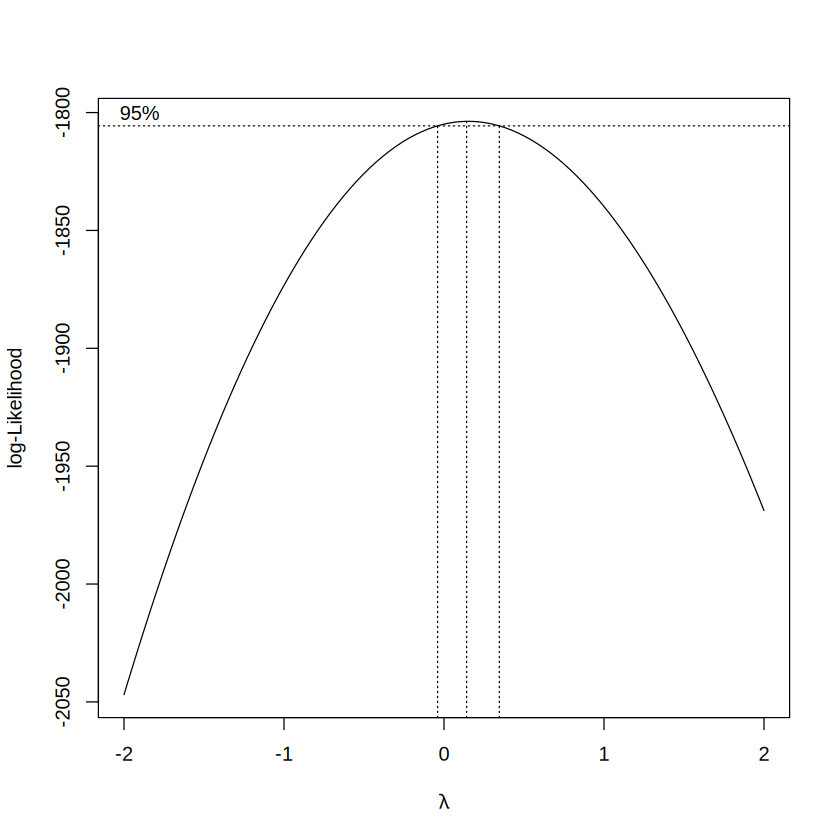

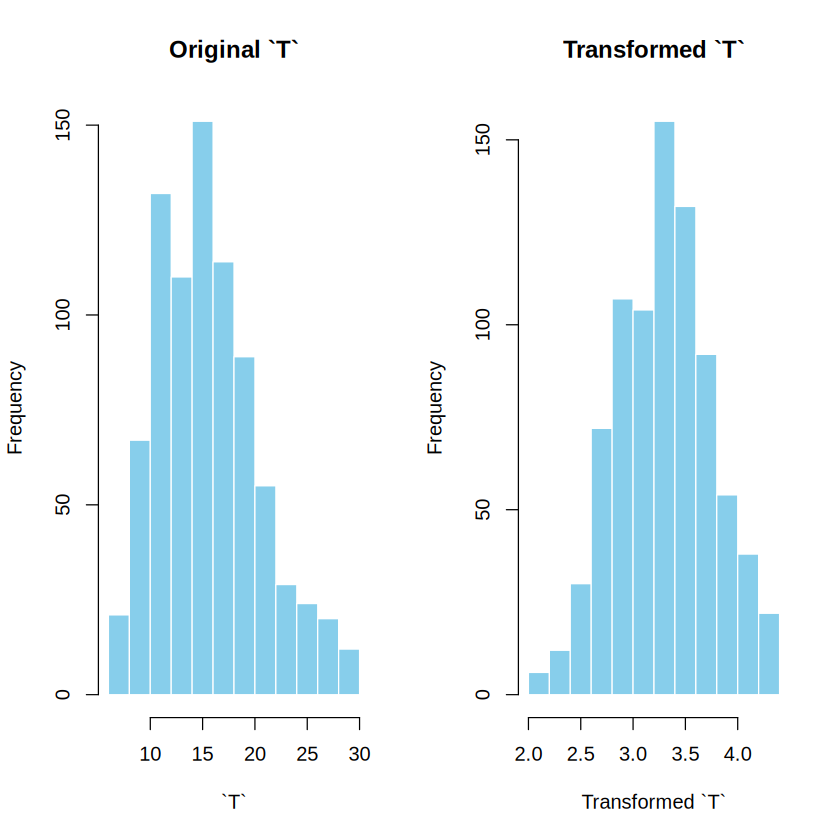

In [71]:
response_variable <- air_quality$`T`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `T`", xlab = "`T`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `T`", xlab = "Transformed `T`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [72]:
air_quality$`T` <- transformed_response

### 12. RH: Relative humidity (%)

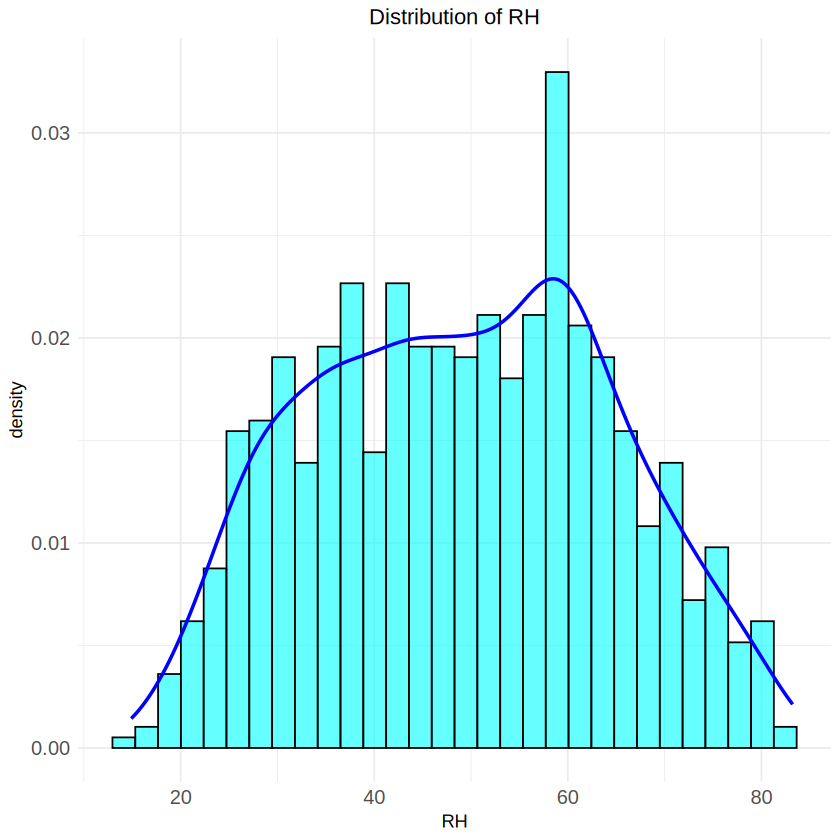

In [73]:
ggplot(air_quality, aes(x = `RH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of RH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

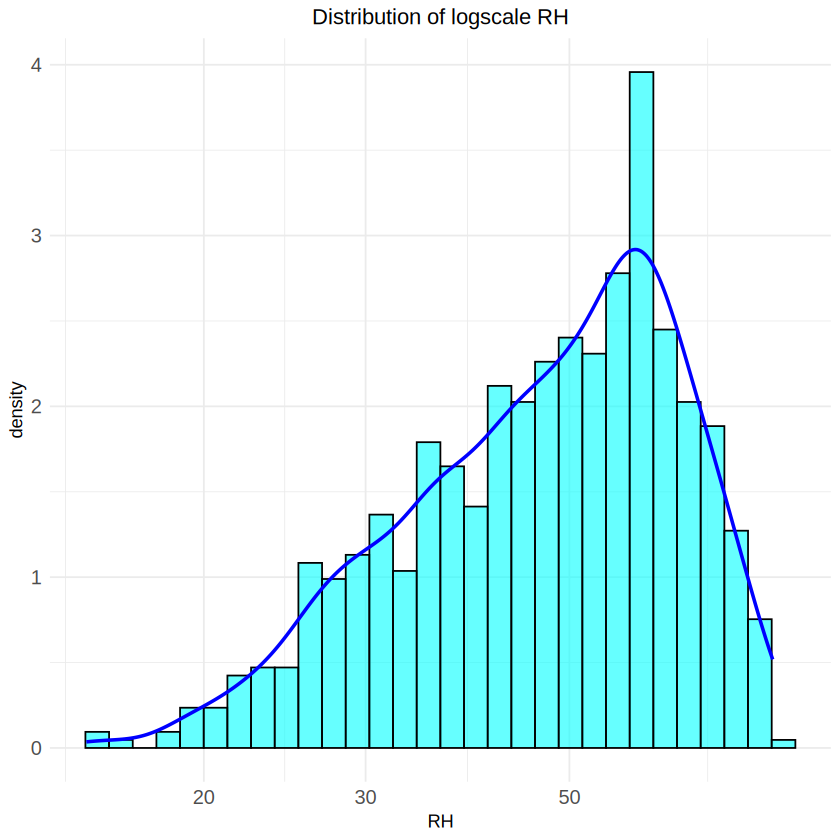

In [74]:
ggplot(air_quality, aes(x = `RH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale RH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.828282828282829"


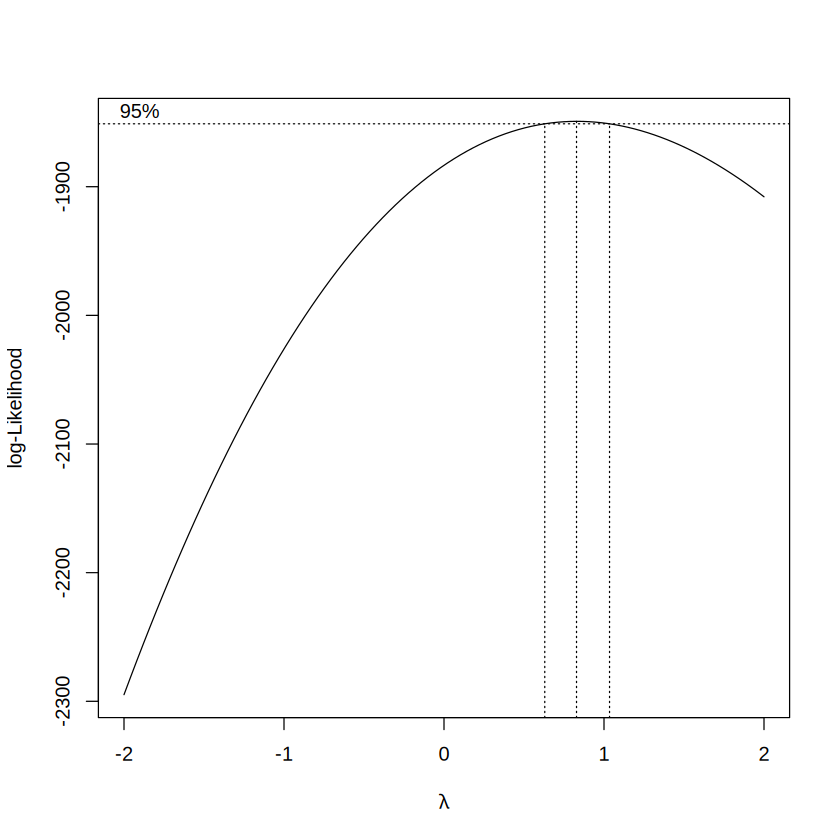

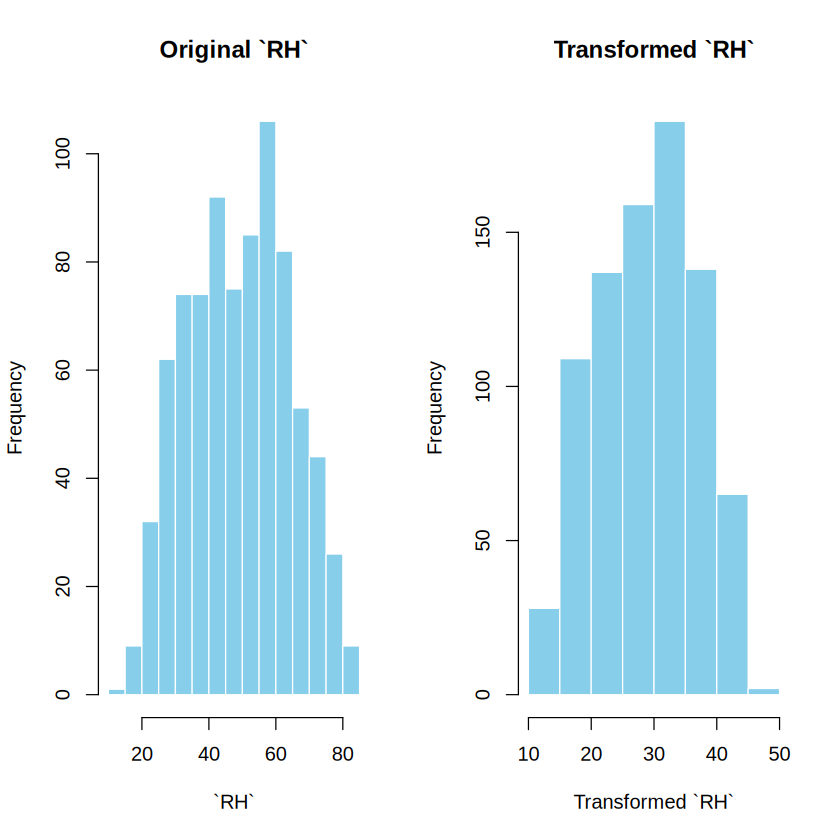

In [75]:
response_variable <- air_quality$`RH`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `RH`", xlab = "`RH`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `RH`", xlab = "Transformed `RH`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [76]:
air_quality$`RH` <- transformed_response

### 13. AH: Absolute humidity (g/m³)

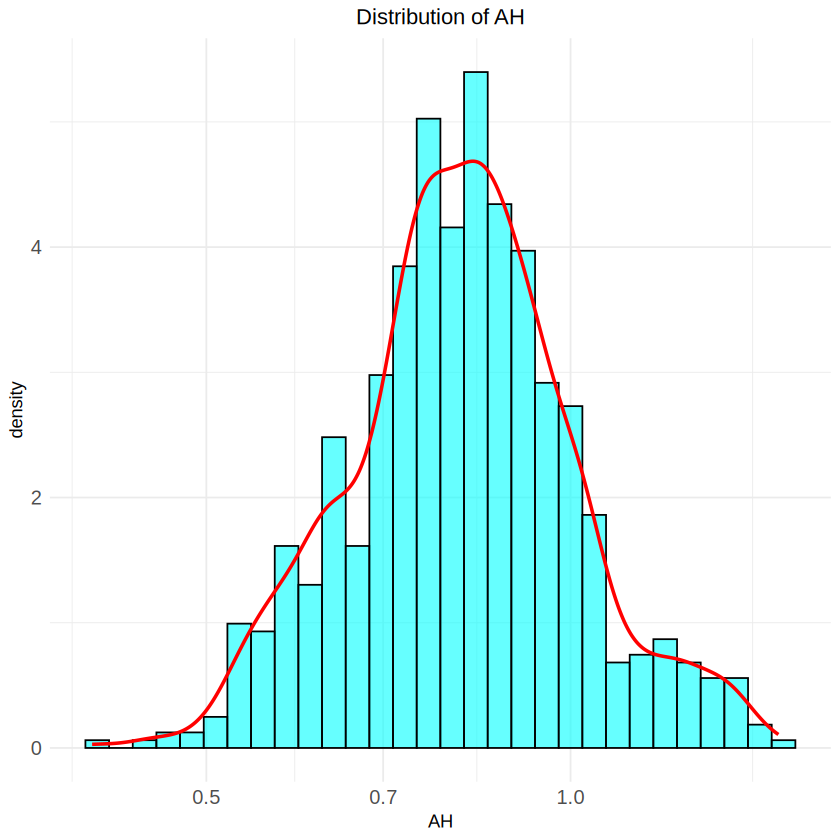

In [77]:
ggplot(air_quality, aes(x = `AH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of AH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

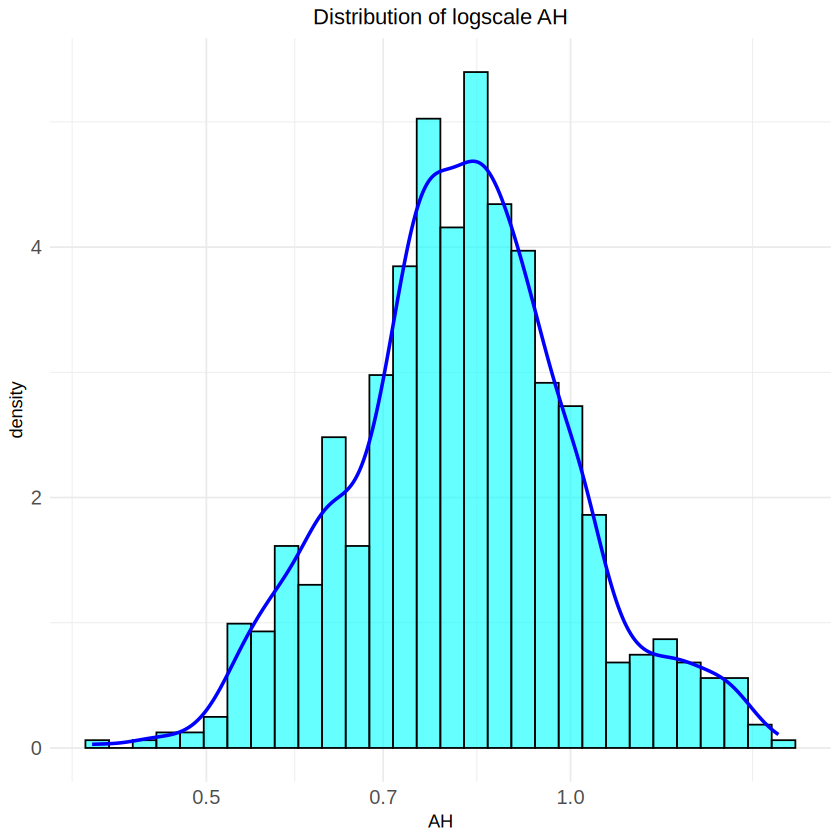

In [78]:
ggplot(air_quality, aes(x = `AH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale AH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  -0.101010101010101"


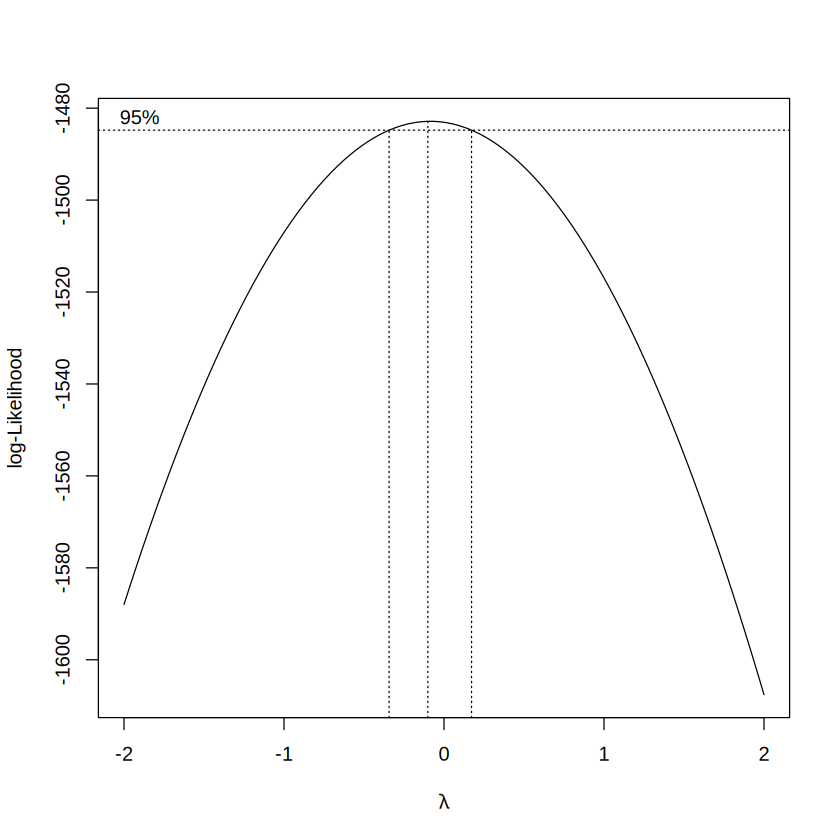

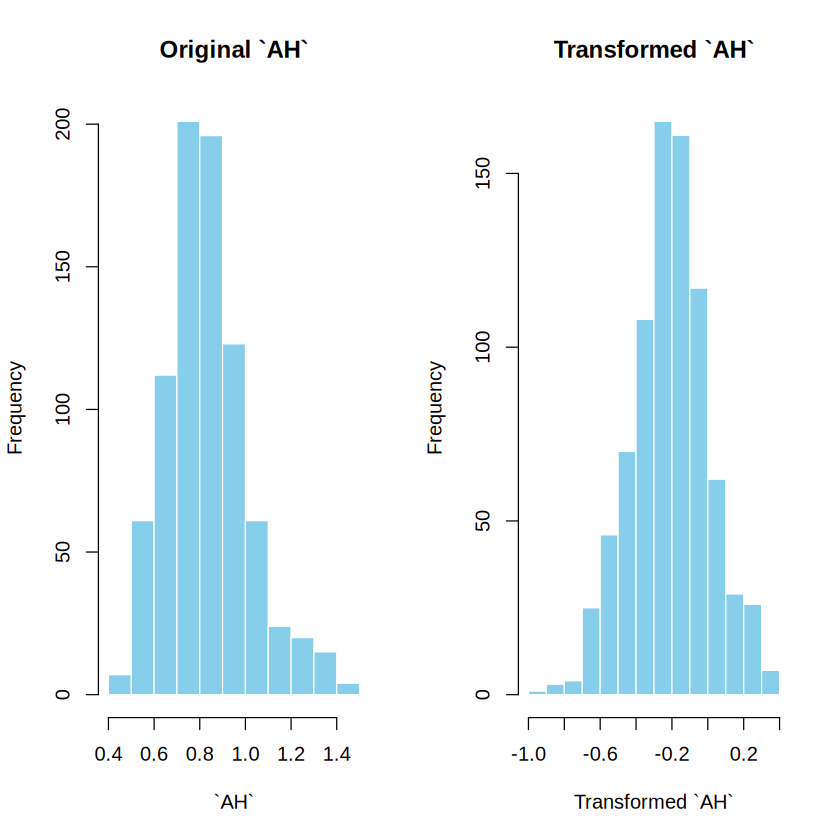

In [79]:
response_variable <- air_quality$`AH`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `AH`", xlab = "`AH`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `AH`", xlab = "Transformed `AH`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [80]:
air_quality$`AH` <- transformed_response

## Phân chia tập dữ liệu

In [81]:
air_quality <- air_quality[, -c(1, 2)]

In [82]:
split_ratio <- 0.7
split_index <- floor(nrow(air_quality) * split_ratio)

train = air_quality[1:split_index,]
test = air_quality[(split_index + 1):nrow(air_quality),]

In [83]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 576  13

In [84]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 248  13

In [85]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	576 obs. of  13 variables:
 $ CO.GT.       : num  1.086 0.76 0.876 0.876 0.5 ...
 $ PT08.S1.CO.  : num  2.93 2.92 2.93 2.93 2.92 ...
 $ NMHC.GT.     : num  6.52 6.05 5.66 5.51 4.83 ...
 $ C6H6.GT.     : num  3.9 3.37 3.28 3.33 2.63 ...
 $ PT08.S2.NMHC.: num  35 33.7 33.4 33.6 31.9 ...
 $ NOx.GT.      : num  15.9 12.8 14.3 16.2 14.3 ...
 $ PT08.S3.NOx. : num  2.9 2.91 2.91 2.9 2.92 ...
 $ NO2.GT.      : num  79.8 66 80.4 85.6 81.7 ...
 $ PT08.S4.NO2. : num  2.08 2.08 2.08 2.08 2.08 ...
 $ PT08.S5.O3.  : num  110.5 94.4 100.1 107.2 102.1 ...
 $ T            : num  3.16 3.12 2.97 2.85 2.87 ...
 $ RH           : num  29.1 28.4 31.6 34.7 34.4 ...
 $ AH           : num  -0.281 -0.326 -0.292 -0.243 -0.24 ...


## Mô hình hóa

### Mô hình đầy đủ

In [86]:
full.lm <- lm(`C6H6.GT.` ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = C6H6.GT. ~ ., data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.119544 -0.005796  0.001403  0.009158  0.026607 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -4.054e+00  1.413e+00  -2.870 0.004261 ** 
CO.GT.         1.305e-02  6.569e-03   1.986 0.047500 *  
PT08.S1.CO.   -4.429e-01  1.325e-01  -3.344 0.000881 ***
NMHC.GT.      -1.156e-02  1.821e-03  -6.351 4.40e-10 ***
PT08.S2.NMHC.  4.137e-01  1.732e-03 238.838  < 2e-16 ***
NOx.GT.        3.759e-04  7.374e-04   0.510 0.610393    
PT08.S3.NOx.  -7.675e-01  1.232e-01  -6.230 9.13e-10 ***
NO2.GT.        3.015e-04  9.290e-05   3.245 0.001244 ** 
PT08.S4.NO2.  -1.454e+00  7.179e-01  -2.025 0.043371 *  
PT08.S5.O3.   -9.733e-05  1.009e-04  -0.965 0.335054    
T              1.121e-02  1.002e-02   1.119 0.263536    
RH             1.073e-03  6.876e-04   1.561 0.119107    
AH            -1.794e-02  1.717e-02  -1.045 0.296656    
---
Signif. codes:  0 ‘**

### Lựa chọn mô hình

In [87]:
# Mô hình chặn dưới
model.lb <- lm(`C6H6.GT.` ~ 1, data = train) 

In [88]:
# Mô hình chặn trên
model.up <- full.lm

In [89]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = C6H6.GT. ~ CO.GT. + PT08.S1.CO. + NMHC.GT. + PT08.S2.NMHC. + 
    PT08.S3.NOx. + NO2.GT. + PT08.S4.NO2. + RH, data = train)

Coefficients:
  (Intercept)         CO.GT.    PT08.S1.CO.       NMHC.GT.  PT08.S2.NMHC.  
   -3.7626099      0.0140691     -0.4869658     -0.0107162      0.4139599  
 PT08.S3.NOx.        NO2.GT.   PT08.S4.NO2.             RH  
   -0.7152385      0.0002943     -1.5827491      0.0003227  


In [90]:
csm_models<- regsubsets(`C6H6.GT.` ~  PT08.S1.CO. + NMHC.GT. + PT08.S2.NMHC. + NOx.GT. + PT08.S3.NOx. + NO2.GT. + PT08.S4.NO2. + T + RH, data = train)
summary.csm<-summary(csm_models)

In [91]:
# Lựa chọn mô hình tốt nhất từ reg subsets 
summary.csm$which

(Intercept) PT08.S1.CO. NMHC.GT. PT08.S2.NMHC. NOx.GT. PT08.S3.NOx. NO2.GT.
1 TRUE        FALSE       FALSE    TRUE          FALSE   FALSE        FALSE  
2 TRUE        FALSE       FALSE    TRUE          FALSE    TRUE        FALSE  
3 TRUE        FALSE        TRUE    TRUE          FALSE    TRUE        FALSE  
4 TRUE        FALSE        TRUE    TRUE          FALSE    TRUE        FALSE  
5 TRUE         TRUE        TRUE    TRUE          FALSE    TRUE         TRUE  
6 TRUE         TRUE        TRUE    TRUE          FALSE    TRUE         TRUE  
7 TRUE         TRUE        TRUE    TRUE          FALSE    TRUE         TRUE  
8 TRUE         TRUE        TRUE    TRUE           TRUE    TRUE         TRUE  
  PT08.S4.NO2. T     RH   
1 FALSE        FALSE FALSE
2 FALSE        FALSE FALSE
3 FALSE        FALSE FALSE
4  TRUE        FALSE FALSE
5 FALSE        FALSE FALSE
6 FALSE         TRUE FALSE
7  TRUE        FALSE  TRUE
8  TRUE        FALSE  TRUE

Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [92]:
summary.csm$rsq

[1] 0.9998875 0.9998895 0.9998927 0.9998964 0.9998994 0.9999009 0.9999026
[8] 0.9999029

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [93]:
# model with largest adjusted R^2 
summary.csm$adjr2

[1] 0.9998873 0.9998891 0.9998921 0.9998956 0.9998986 0.9998998 0.9999014
[8] 0.9999015

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [94]:
# model with smallest Mallow's Cp
summary.csm$cp

[1] 83.845376 74.084060 57.606625 38.062269 22.186383 15.891633  7.690513
[8]  8.041191

Chọn mô hình tốt nhất dựa trên BIC

In [95]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.csm$bic

[1] -5224.538 -5228.605 -5239.014 -5252.844 -5263.791 -5265.643 -5269.546
[8] -5264.866

In [96]:
best_model_index <- which.min(summary.csm$bic)
best_model <- summary.csm$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

  (Intercept)   PT08.S1.CO.      NMHC.GT. PT08.S2.NMHC.       NOx.GT. 
         TRUE          TRUE          TRUE          TRUE         FALSE 
 PT08.S3.NOx.       NO2.GT.  PT08.S4.NO2.             T            RH 
         TRUE          TRUE          TRUE         FALSE          TRUE 
[1] "PT08.S1.CO."   "NMHC.GT."      "PT08.S2.NMHC." "PT08.S3.NOx." 
[5] "NO2.GT."       "PT08.S4.NO2."  "RH"           


In [97]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("C6H6.GT. ~", paste(best_vars, collapse = " + "))
best_model_csm <- lm(as.formula(formula_str), data=train)

In [98]:
# Tóm tắt mô hình
summary(best_model_csm)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.121870 -0.006295  0.001303  0.008990  0.025985 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -3.370e+00  1.131e+00  -2.979 0.003016 ** 
PT08.S1.CO.   -3.716e-01  1.081e-01  -3.437 0.000630 ***
NMHC.GT.      -9.335e-03  1.556e-03  -5.997 3.57e-09 ***
PT08.S2.NMHC.  4.164e-01  1.116e-03 373.211  < 2e-16 ***
PT08.S3.NOx.  -6.562e-01  9.860e-02  -6.655 6.70e-11 ***
NO2.GT.        3.448e-04  7.998e-05   4.311 1.92e-05 ***
PT08.S4.NO2.  -2.057e+00  5.400e-01  -3.809 0.000155 ***
RH             4.407e-04  1.184e-04   3.721 0.000218 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0154 on 568 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9999 
F-statistic: 8.331e+05 on 7 and 568 DF,  p-value: < 2.2e-16


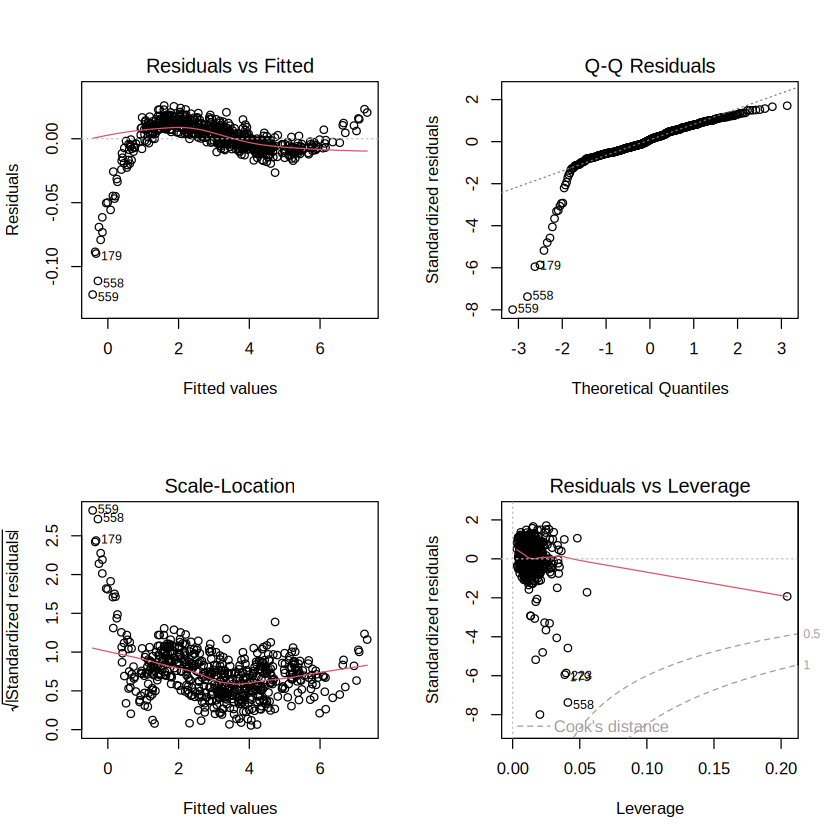

In [99]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_csm)

#### Phân tích Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

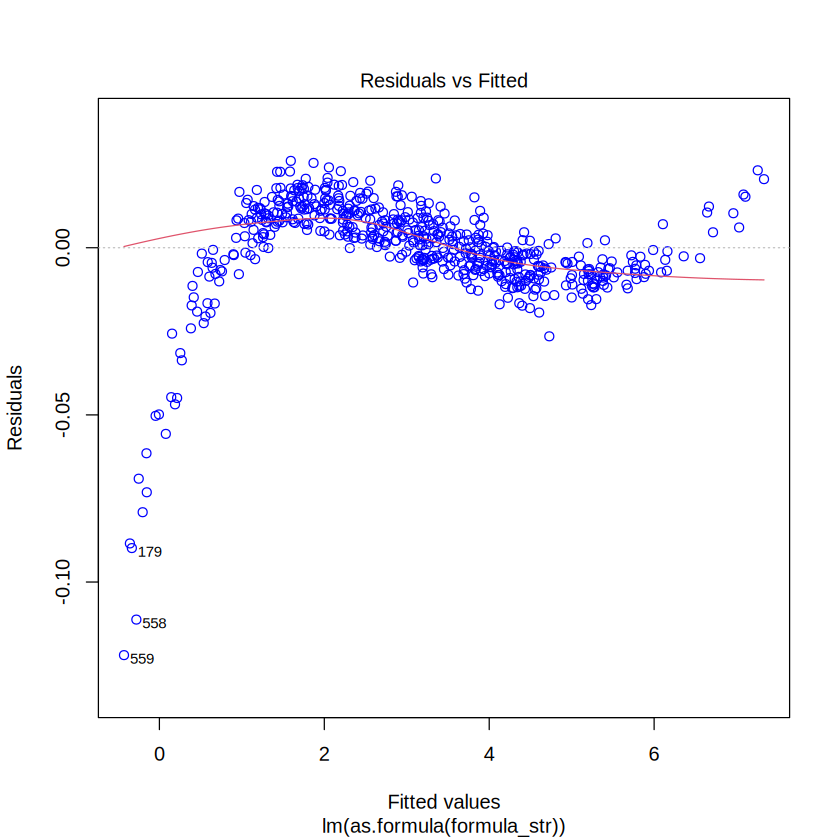

In [100]:
plot(best_model_csm, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Phân tích Normal Q–Q (quantile-quantile) Plot

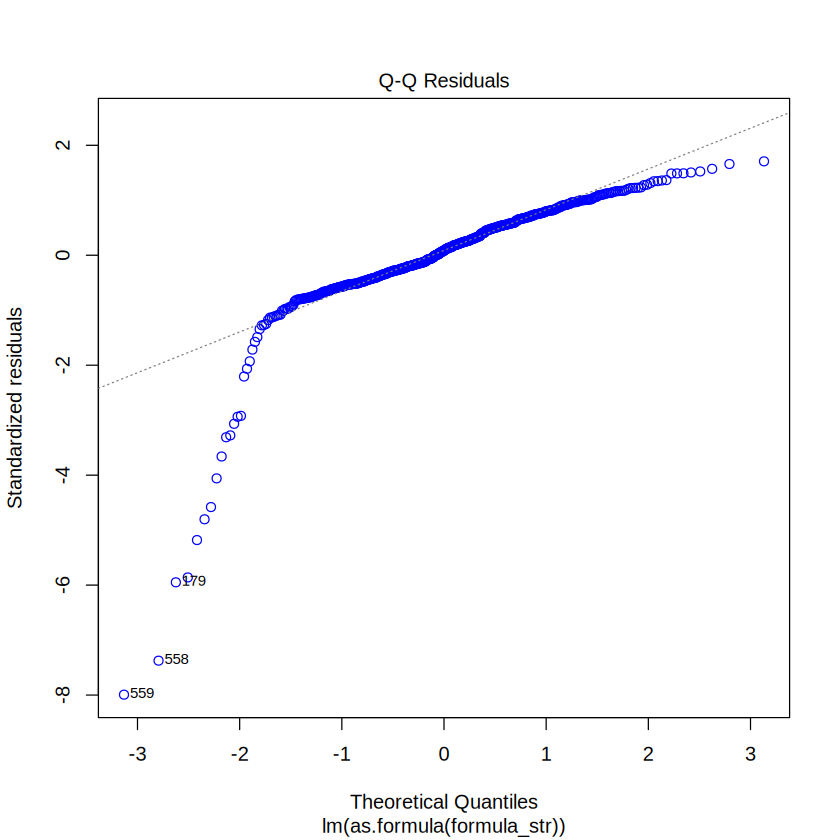

In [101]:
plot(best_model_csm, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [102]:
# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm))


	Shapiro-Wilk normality test

data:  residuals(best_model_csm)
W = 0.75916, p-value < 2.2e-16


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Phân tích Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

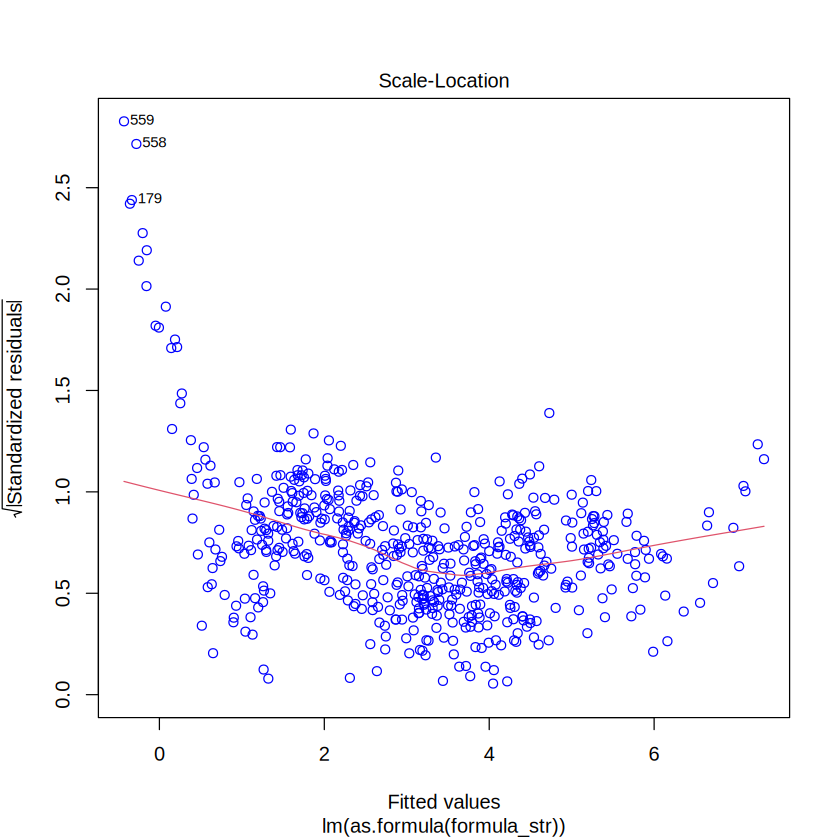

In [103]:
plot(best_model_csm, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [104]:
# Breusch-Pagan Test
bptest(best_model_csm)


	studentized Breusch-Pagan test

data:  best_model_csm
BP = 84.171, df = 7, p-value = 1.937e-15


Như vậy, ta thấy p-value nhỏ hơn múc ý nghĩa 0.05, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là homoscedastic

#### Phân tích Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

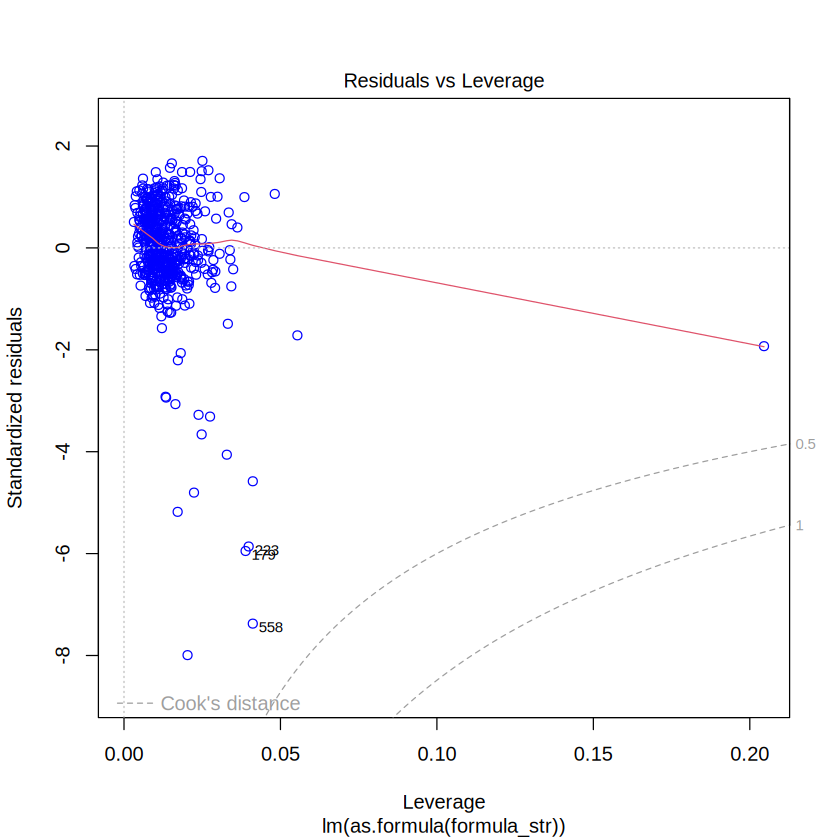

In [105]:
plot(best_model_csm, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

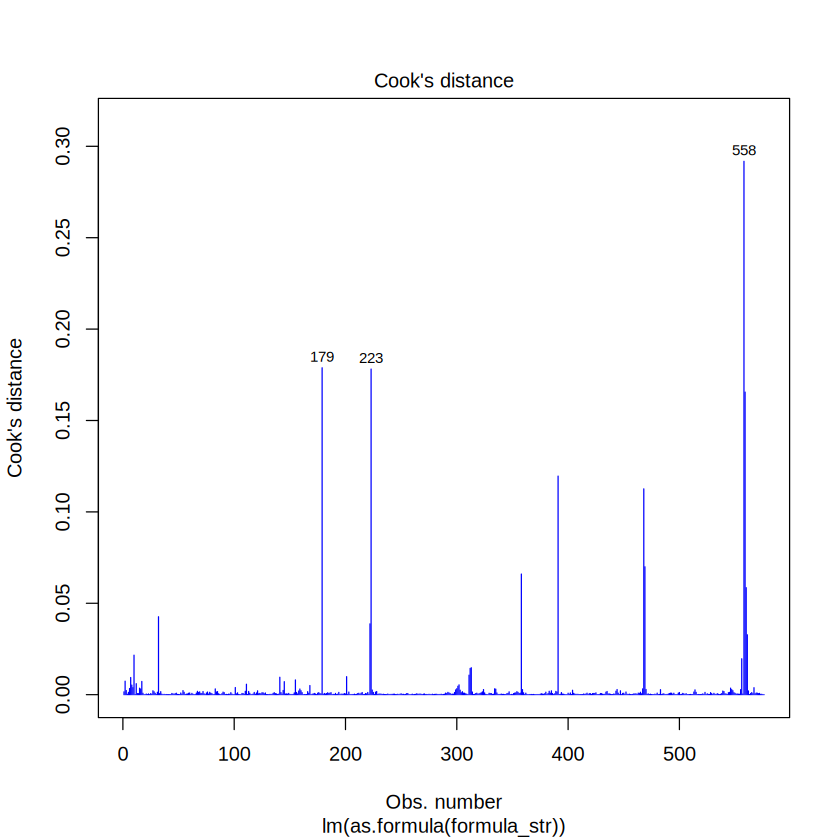

In [106]:
plot(best_model_csm, which=4, col=c("blue"))

Kết luận:
- Mô hình thu được có thể được sử dụng để đem đi dự đoán.

#### Dự đoán và đánh giá kết quả

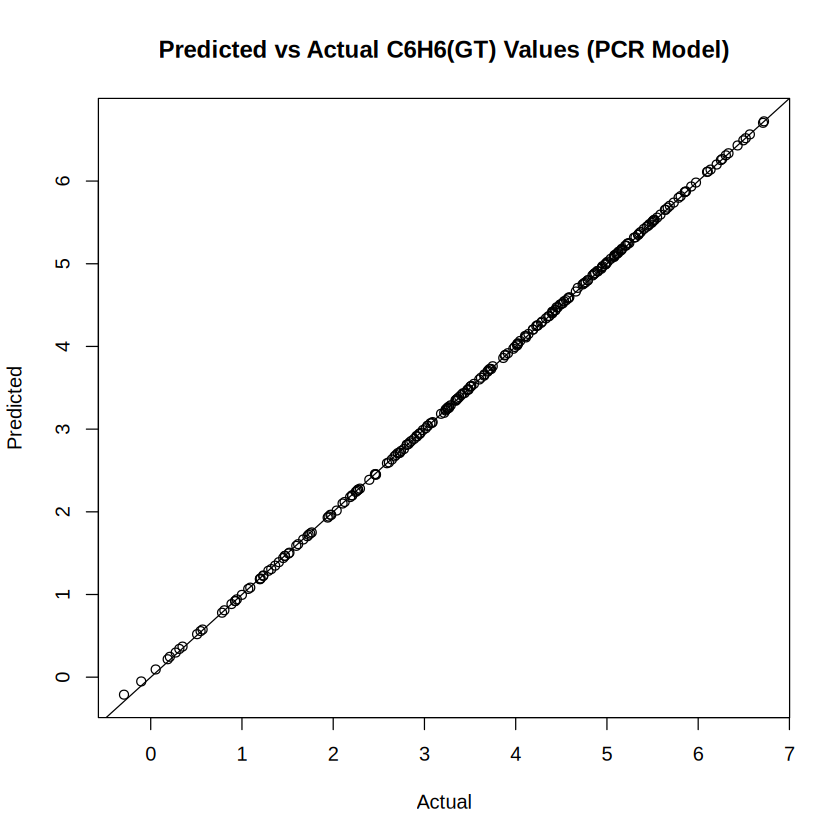

In [107]:
# Predict using the model and evaluate on the test set
predictions <- predict(best_model_csm, test)

# Compare predictions with actual values
plot(test$`C6H6.GT.`, predictions, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (PCR Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [108]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`C6H6.GT.` - predictions)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 


[1] "RMSE:  0.0130277636824247"


In [109]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`C6H6.GT.` - predictions)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.999936208565972"


## Mô hình hóa bằng PCR

In [110]:
# Fitting the PCR model on the training data
pcr_model <- pcr(`C6H6.GT.` ~ ., data = train, scale = TRUE, validation = "CV") # Fit PCR model with cross-validation

In [111]:
summary(pcr_model)

Data: 	X dimension: 576 12 
	Y dimension: 576 1
Fit method: svdpc
Number of components considered: 12

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           1.553   0.2452   0.2301   0.1964   0.1805   0.1696   0.1594
adjCV        1.553   0.2451   0.2300   0.1963   0.1804   0.1696   0.1593
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps
CV      0.1599   0.1275   0.1144    0.1151   0.09212   0.01574
adjCV   0.1600   0.1273   0.1143    0.1148   0.09254   0.01571

TRAINING: % variance explained
          1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X           70.72    87.67    94.46    96.97    98.12    98.84    99.23
C6H6.GT.    97.51    97.82    98.41    98.66    98.82    98.96    98.97
          8 comps  9 comps  10 comps  11 comps  12 comps
X           99.54    99.73     99.88     99.95    100.00
C6H6.GT.    99.36    99.51     99.54     99.75     99.99


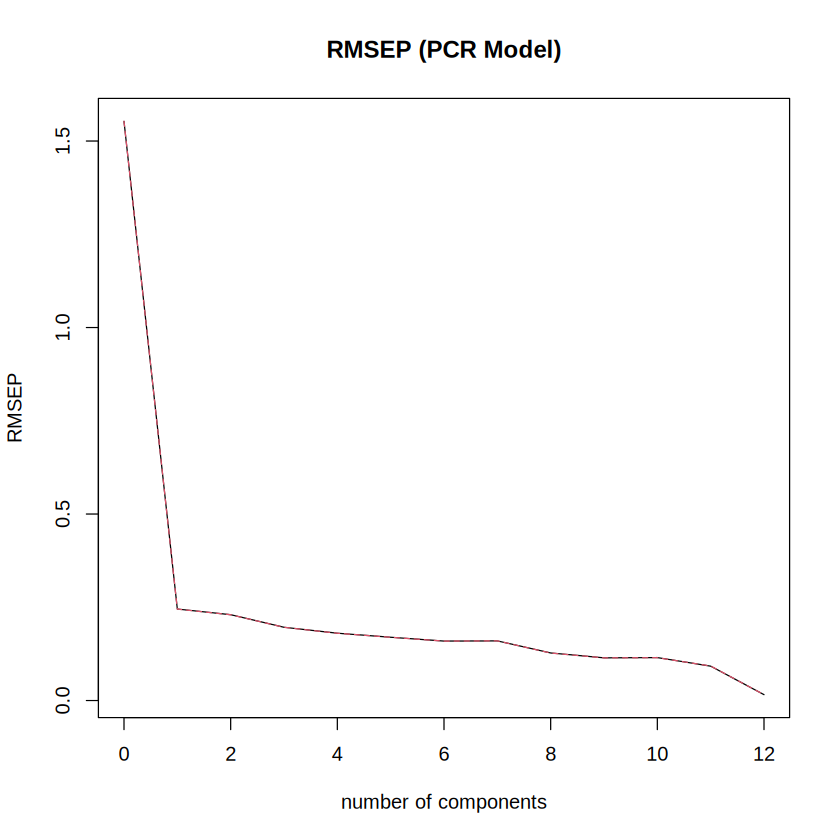

In [112]:
# Plotting the RMSEP (Root Mean Squared Error of Prediction) to find the optimal number of components
validationplot(pcr_model, val.type = "RMSEP", main = "RMSEP (PCR Model)")

In [113]:
# Predict using the model and evaluate on the test set with optimal number of components
optimal_number_of_components <- 6  # Optimal number of components based on the RMSEP plot and summary
predictions <- predict(pcr_model, ncomp = optimal_number_of_components, newdata = test)  

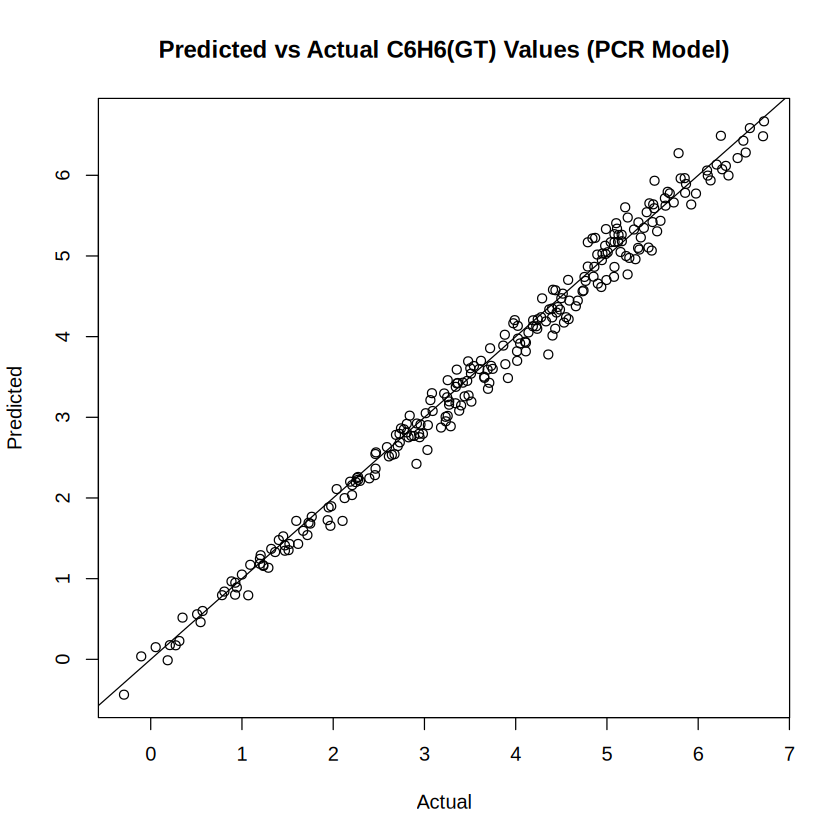

In [114]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, predictions, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (PCR Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [115]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`C6H6.GT.` - predictions)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 

[1] "RMSE:  0.187198443665184"


In [116]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`C6H6.GT.` - predictions)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.986828747102832"


## Mô hình hóa bằng PLS

In [117]:
# Fitting the PLS model on the training data
pls_model <- plsr(`C6H6.GT.` ~ ., data = train, scale = TRUE, validation = "CV")

summary(pls_model)

Data: 	X dimension: 576 12 
	Y dimension: 576 1
Fit method: kernelpls
Number of components considered: 12

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           1.553   0.2322   0.1918   0.1702   0.1420   0.1108  0.08611
adjCV        1.553   0.2321   0.1917   0.1701   0.1419   0.1107  0.08589
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps
CV     0.07225  0.03254  0.01811   0.01653   0.01592   0.01580
adjCV  0.07174  0.03212  0.01788   0.01646   0.01589   0.01577

TRAINING: % variance explained
          1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X           70.71    84.32    93.71    96.40    97.67    98.39    99.01
C6H6.GT.    97.78    98.50    98.82    99.19    99.52    99.74    99.84
          8 comps  9 comps  10 comps  11 comps  12 comps
X           99.23    99.43     99.77     99.89    100.00
C6H6.GT.    99.96    99.99     99.99     99.99     99.99


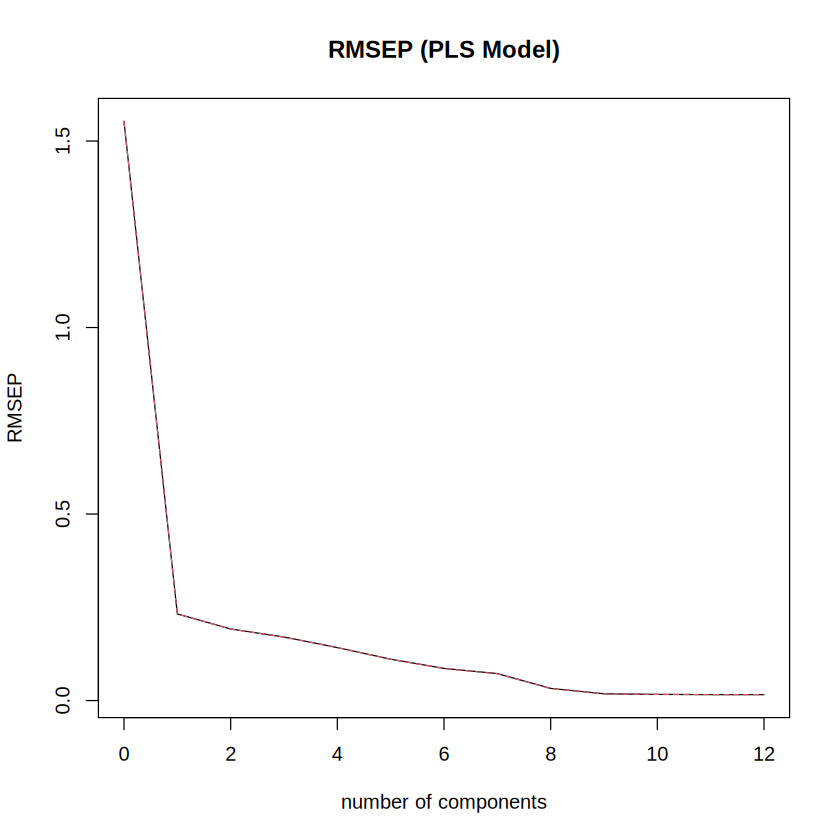

In [118]:
# Plotting the RMSEP (Root Mean Squared Error of Prediction) to find the optimal number of components
validationplot(pls_model, val.type = "RMSEP", main = "RMSEP (PLS Model)")

In [119]:
# Predict using the model and evaluate on the test set with optimal number of components
optimal_number_of_components <- 6  # Optimal number of components based on the RMSEP plot and summary
predictions2 <- predict(pls_model, ncomp = optimal_number_of_components, newdata = test)  

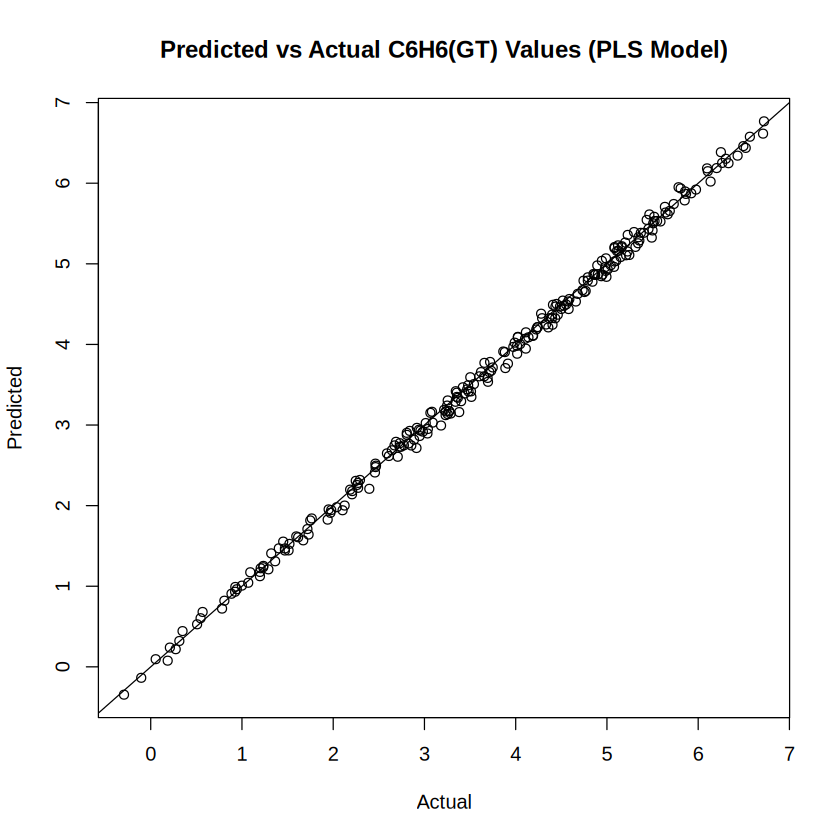

In [120]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, predictions2, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (PLS Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [121]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse2 <- sqrt(mean((test$`C6H6.GT.` - predictions2)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse2)) 

[1] "RMSE:  0.0780587923598391"


In [122]:
# Calculate the sum of squares of residuals
ss_res2 <- sum((test$`C6H6.GT.` - predictions2)^2)

# Calculate the total sum of squares
ss_tot2 <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared2 <- 1 - (ss_res2 / ss_tot2)

# Print R-squared
print(paste("R-squared: ", r_squared2))

[1] "R-squared:  0.997709837615491"


## ANOVA Một nhân tố

In [123]:
anova_train <- aov(formula = `C6H6.GT.` ~ ., data = train)
summary(anova_train)

               Df Sum Sq Mean Sq   F value   Pr(>F)    
CO.GT.          1 1333.3  1333.3 5.653e+06  < 2e-16 ***
PT08.S1.CO.     1    1.4     1.4 5.838e+03  < 2e-16 ***
NMHC.GT.        1   12.4    12.4 5.265e+04  < 2e-16 ***
PT08.S2.NMHC.   1   36.8    36.8 1.562e+05  < 2e-16 ***
NOx.GT.         1    0.0     0.0 7.638e+00  0.00590 ** 
PT08.S3.NOx.    1    0.0     0.0 4.938e+01 6.12e-12 ***
NO2.GT.         1    0.0     0.0 1.056e+01  0.00123 ** 
PT08.S4.NO2.    1    0.0     0.0 2.986e+00  0.08455 .  
PT08.S5.O3.     1    0.0     0.0 1.006e+00  0.31629    
T               1    0.0     0.0 3.810e+00  0.05143 .  
RH              1    0.0     0.0 1.962e+00  0.16186    
AH              1    0.0     0.0 1.091e+00  0.29666    
Residuals     563    0.1     0.0                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Random forest

In [124]:
library(randomForest)

set.seed(123)
model_rf <- randomForest(x = train[,-c(4)],
                         y = train$`C6H6.GT.`, 
                         ntree = 500)

model_rf

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine





Call:
 randomForest(x = train[, -c(4)], y = train$C6H6.GT., ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 0.007184586
                    % Var explained: 99.7

In [125]:
library(MLmetrics)
library(performance)

pred_rf_val <- predict(object = model_rf, newdata = test)


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall



Attaching package: ‘performance’


The following objects are masked from ‘package:Metrics’:

    mae, mse, rmse




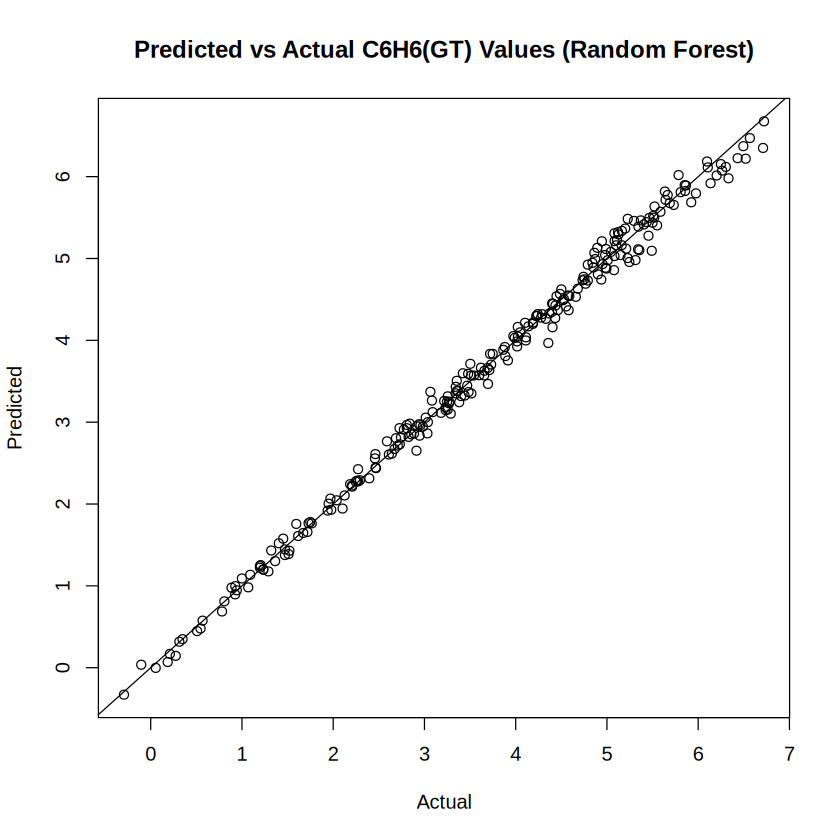

In [126]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, pred_rf_val, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (Random Forest)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [127]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse2 <- sqrt(mean((test$`C6H6.GT.` - pred_rf_val)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse2)) 

[1] "RMSE:  0.122079053079136"


In [128]:
# Calculate the sum of squares of residuals
ss_res2 <- sum((test$`C6H6.GT.` - pred_rf_val)^2)

# Calculate the total sum of squares
ss_tot2 <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared2 <- 1 - (ss_res2 / ss_tot2)

# Print R-squared
print(paste("R-squared: ", r_squared2))

[1] "R-squared:  0.994398492458925"


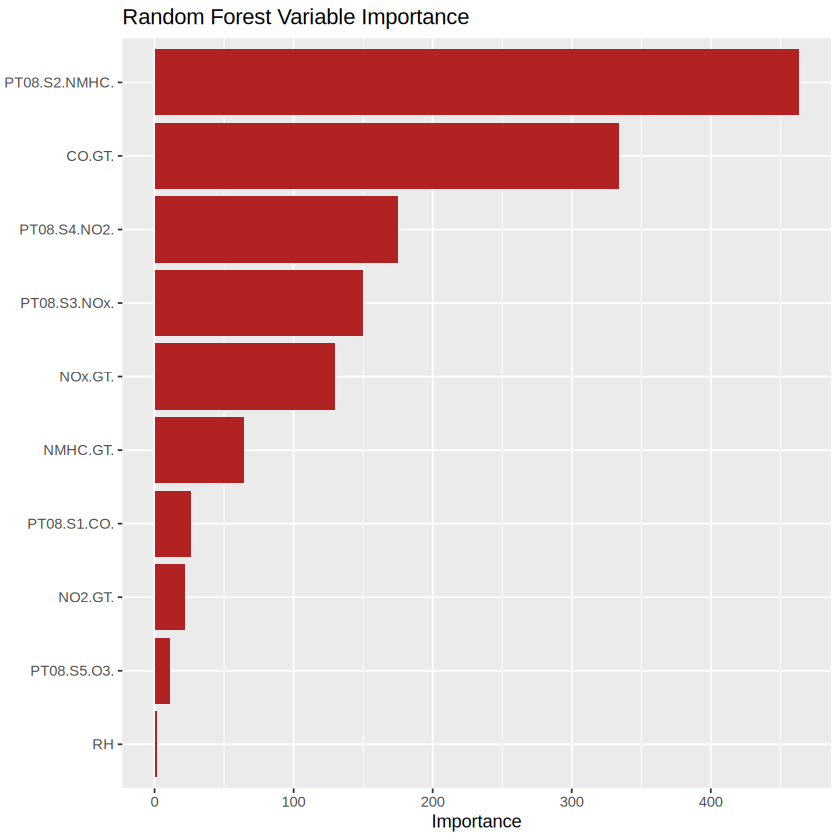

In [129]:
library("tibble")
model_rf$importance %>% 
  as.data.frame() %>% 
  arrange(-IncNodePurity) %>% 
  rownames_to_column("variable") %>% 
  head(10) %>% 
  ggplot(aes(IncNodePurity, 
             reorder(variable, IncNodePurity))
         ) +
  geom_col(fill = "firebrick") +
  labs(x = "Importance",
       y = NULL,
       title = "Random Forest Variable Importance")

In [130]:
library(lime)

set.seed(123)
explainer <- lime(x = test[,-c(4)],
                  model = model_rf)

model_type.randomForest <- function(x){
  return("regression") # for regression problem
}

predict_model.randomForest <- function(x, newdata, type = "response") {

    # return prediction value
    predict(x, newdata) %>% as.data.frame()
    
}

#  Select only the first 4 observations
selected_data <- test[,-c(4)] %>% 
  slice(1:4)

#  Explain the model
set.seed(123)
explanation <- explain(x = selected_data, 
                       explainer = explainer,
                       n_features = 27 #  Number of features to explain the model
                       )


Attaching package: ‘lime’


The following object is masked from ‘package:dplyr’:

    explain





Attaching package: ‘plotly’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




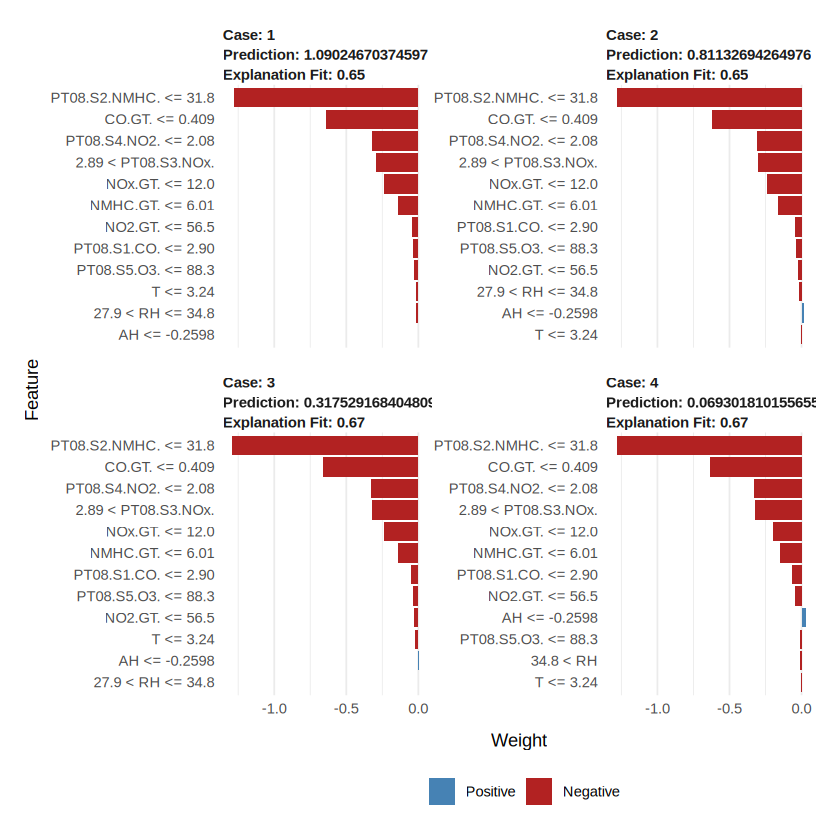

In [131]:
library(plotly)

plot_features(explanation = explanation)

## Support Vector Machine

In [132]:
library(e1071)
model_svm <- svm(`C6H6.GT.` ~ ., data = train)
pred_svm_val <- predict(object = model_svm, newdata = test)

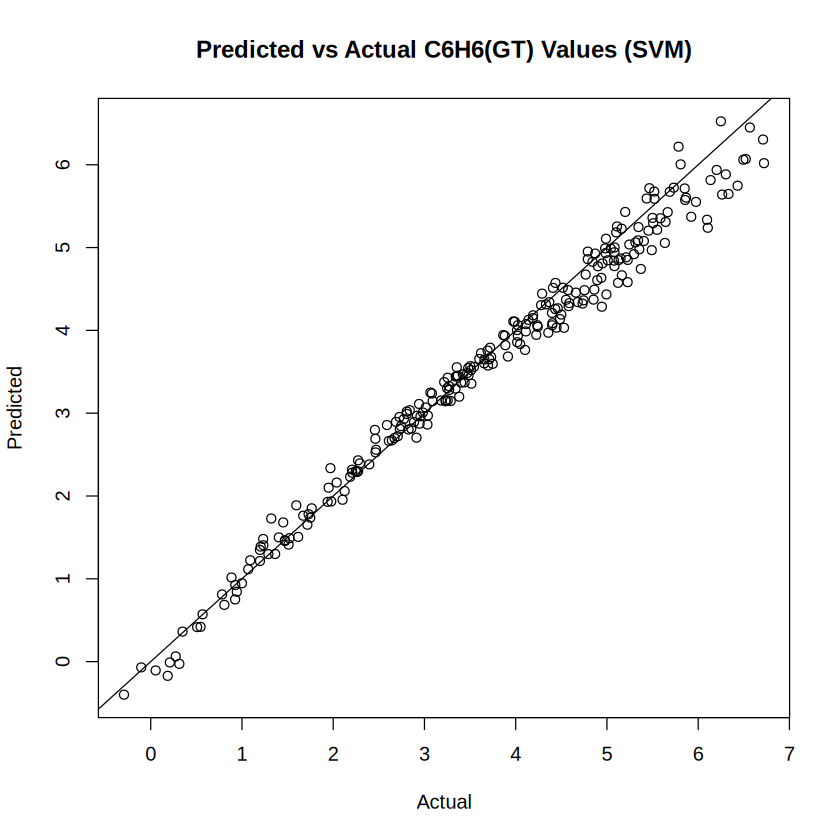

In [133]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, pred_svm_val, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (SVM)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [134]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse2 <- sqrt(mean((test$`C6H6.GT.` - pred_svm_val)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse2)) 

[1] "RMSE:  0.244725934774108"


In [135]:
# Calculate the sum of squares of residuals
ss_res2 <- sum((test$`C6H6.GT.` - pred_svm_val)^2)

# Calculate the total sum of squares
ss_tot2 <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared2 <- 1 - (ss_res2 / ss_tot2)

# Print R-squared
print(paste("R-squared: ", r_squared2))

[1] "R-squared:  0.977489631055161"


Lime Interpretation

In [136]:
library(lime)

# create the explanation for the SVR model.
set.seed(123)
explainer_svm <- lime(x = train[,-c(4)], 
                  model = model_svm)

# Create SVR model specification for lime.
model_type.svm <- function(x){
  return("regression") # for regression problem
}

predict_model.svm <- function(x, newdata, type = "response") {

    # return prediction value
    predict(x, newdata) %>% as.data.frame()
    
}

In [137]:
set.seed(123)
explanation_svm <- explain(x = selected_data, 
                       explainer = explainer_svm,
                       kernel_width = 1,
                       feature_select = "auto", # Method of feature selection for lime
                       n_features = 10 # Number of features to explain the model
                       )


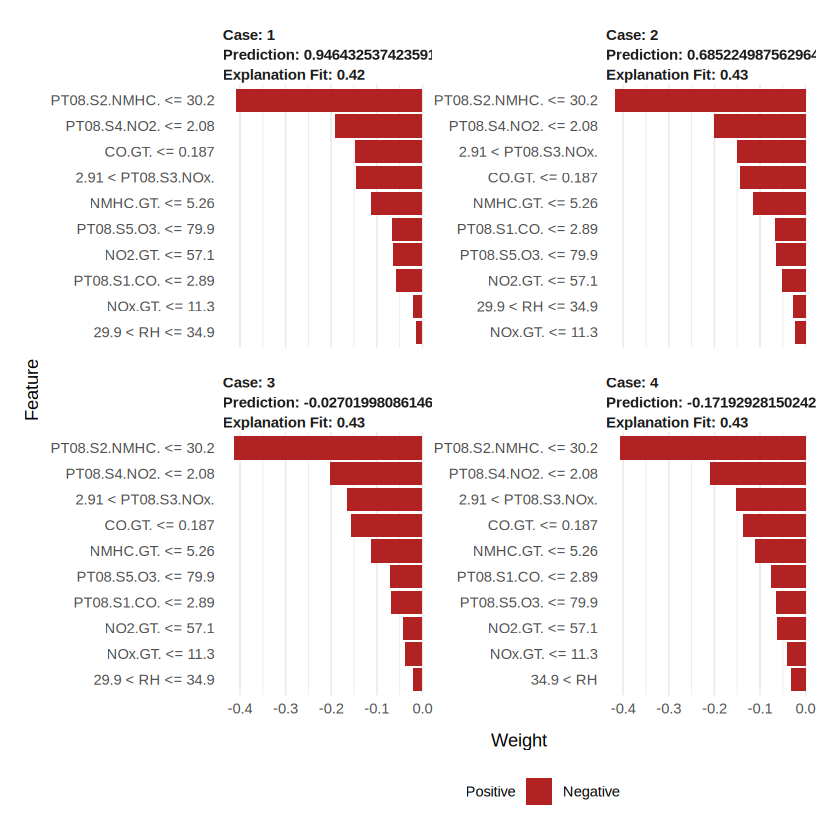

In [138]:
set.seed(123)
explanation_svm <- explain(x = selected_data, 
                       explainer = explainer_svm,
                       kernel_width = 1,
                       feature_select = "auto", # Method of feature selection for lime
                       n_features = 10 # Number of features to explain the model
                       )

plot_features(explanation_svm)

## So sánh các mô hình

## Kết luận